# **Problem Statement**

- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like:
    - Demographics (city, age, gender etc.)
    - Tenure information (joining date, Last Date)
    - Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


**Column Profiling:**
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

# **Loading dependencies and dataset**

In [799]:
# !pip install python-Levenshtein
# !pip install fuzzywuzzy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from fuzzywuzzy import fuzz

# from scipy.stats import levene, f_oneway, kruskal
# from scipy.stats import ttest_ind
# from scipy.stats import chi2_contingency
# from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


import plotly.express as px


In [398]:
df = pd.read_csv('./data/ola_driver.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


# **Basic checks on the data**

In [399]:
df.shape

(19104, 14)

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [401]:
df.columns = [('_').join(col.split()) for col in df.columns]
df.columns

Index(['Unnamed:_0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining_Designation', 'Grade', 'Total_Business_Value',
       'Quarterly_Rating'],
      dtype='object')

In [402]:
# Converting date columns to datetime datatype
df['Join_Date'] = pd.to_datetime(df['Dateofjoining'])
df['Join_Date'] = pd.to_datetime(df['Join_Date'].dt.to_period('M').apply(lambda x: str(x)))
df['Reporting_Date'] = pd.to_datetime(df['MMM-YY'])
df['MoS'] = ((df['Reporting_Date'] - df['Join_Date'])/np.timedelta64(1, 'M')).apply(lambda x: np.round(x+1))
# Creating binary target variable (churn) from LastWorkingDate feature
df['Churn'] = df['LastWorkingDate'].notna().astype(int)

df.drop(['Unnamed:_0', 'Dateofjoining', 'MMM-YY', 'LastWorkingDate'], axis=1, inplace=True)

In [403]:
# Chekcing data types of column again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             19104 non-null  int64         
 1   Age                   19043 non-null  float64       
 2   Gender                19052 non-null  float64       
 3   City                  19104 non-null  object        
 4   Education_Level       19104 non-null  int64         
 5   Income                19104 non-null  int64         
 6   Joining_Designation   19104 non-null  int64         
 7   Grade                 19104 non-null  int64         
 8   Total_Business_Value  19104 non-null  int64         
 9   Quarterly_Rating      19104 non-null  int64         
 10  Join_Date             19104 non-null  datetime64[ns]
 11  Reporting_Date        19104 non-null  datetime64[ns]
 12  MoS                   19104 non-null  float64       
 13  Churn           

In [404]:
# Check for duplicate rows across all columns
df.duplicated(keep='first').sum()

0

In [405]:
# Check for missing values
df.isna().sum()

Driver_ID                0
Age                     61
Gender                  52
City                     0
Education_Level          0
Income                   0
Joining_Designation      0
Grade                    0
Total_Business_Value     0
Quarterly_Rating         0
Join_Date                0
Reporting_Date           0
MoS                      0
Churn                    0
dtype: int64

In [406]:
# Check for missing values (%)
100*df.isna().sum().loc[df.isna().sum()>0]/df.shape[0]

Age       0.319305
Gender    0.272194
dtype: float64

# **Seeing the Structure of the Data** 

In [853]:
# Unique drivers in dataset
df['Driver_ID'].nunique()

2381

In [854]:
# Occurences per each driver
df.groupby('Driver_ID')['Reporting_Date'].count().sort_values(ascending=False)

Driver_ID
2110    24
2617    24
1623    24
1642    24
1644    24
        ..
1614     1
445      1
2397     1
1619     1
469      1
Name: Reporting_Date, Length: 2381, dtype: int64

In [855]:
# Example: Details of a random driver
df.loc[df['Driver_ID']==2716]

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Join_Date,Reporting_Date,MoS,Churn
18568,2716,31.0,1.0,C29,1,38744,1,1,0.0,1,2019-06-01,2019-06-01,1.0,0
18569,2716,31.0,1.0,C29,1,38744,1,1,602840.0,3,2019-06-01,2019-07-01,2.0,0
18570,2716,31.0,1.0,C29,1,38744,1,1,153300.0,3,2019-06-01,2019-08-01,3.0,0
18571,2716,31.0,1.0,C29,1,38744,1,1,736080.0,3,2019-06-01,2019-09-01,4.0,0
18572,2716,31.0,1.0,C29,1,38744,1,1,0.0,2,2019-06-01,2019-10-01,5.0,0
18573,2716,31.0,1.0,C29,1,38744,1,1,200000.0,2,2019-06-01,2019-11-01,6.0,0
18574,2716,32.0,1.0,C29,1,38744,1,1,150010.0,2,2019-06-01,2019-12-01,7.0,0
18575,2716,32.0,1.0,C29,1,38744,1,1,800000.0,2,2019-06-01,2020-01-01,8.0,0
18576,2716,32.0,1.0,C29,1,38744,1,1,0.0,2,2019-06-01,2020-02-01,9.0,0
18577,2716,32.0,1.0,C29,1,38744,1,1,751370.0,2,2019-06-01,2020-03-01,10.0,0


## **Need for Aggregation**

Given the dataset, we will need to aggregaate the data and bring t to 1 record per driver
- From the example above we see that there are multiple records against each driver 
- Some of the features are static features, in the sense that for a single driver they do not change across records
    - Ex: Gender, City, Education_Level etc
    - During aggregation, for each driver: We can take the last values for each of the static features
- Some features are dynamic, in the sense that for a single driver they do change across records
    - Ex: Income, Total_Business_Value, Quarterly_Rating etc
    - During aggregation, for each driver: We need to capture the essence of the information of these dynamic features
    - We will create a few extra features that captures the transients

### **Sanity Checks: Static Columns**

In [856]:
(df.groupby(['Driver_ID'])['Gender'].nunique()>1).sum()

0

In [857]:
(df.groupby(['Driver_ID'])['City'].nunique()>1).sum()

0

In [858]:
(df.groupby(['Driver_ID'])['Education_Level'].nunique()>1).sum()

0

In [859]:
(df.groupby(['Driver_ID'])['Joining_Designation'].nunique()>1).sum()

0

In [860]:
(df.groupby(['Driver_ID'])['Join_Date'].nunique()>1).sum()

0

### **Sanity Checks: Dynamic Columns**

In [861]:
(df.groupby(['Driver_ID'])['Income'].nunique()>1).sum()

44

In [863]:
(df.groupby(['Driver_ID'])['Grade'].nunique()>1).sum()

44

In [862]:
(df.groupby(['Driver_ID'])['Total_Business_Value'].nunique()>1).sum()

1665

In [864]:
(df.groupby(['Driver_ID'])['Quarterly_Rating'].nunique()>1).sum()

1104

## **Imputing Missing Values**

In [412]:
df.isna().sum()

Driver_ID                0
Age                     61
Gender                  52
City                     0
Education_Level          0
Income                   0
Joining_Designation      0
Grade                    0
Total_Business_Value     0
Quarterly_Rating         0
Join_Date                0
Reporting_Date           0
MoS                      0
Churn                    0
dtype: int64

In [865]:
# Since for each driver we have multiple records and Age and Gender are static features, we use the max value across each group to impute them
df['Age'] = df.groupby('Driver_ID')['Age'].transform(lambda x: x.fillna(x.max()))
df['Gender'] = df.groupby('Driver_ID')['Gender'].transform(lambda x: x.fillna(x.max()))

In [866]:
# This way of imputing cleans up all the missing values
df.isna().sum()

Driver_ID               0
Age                     0
Gender                  0
City                    0
Education_Level         0
Income                  0
Joining_Designation     0
Grade                   0
Total_Business_Value    0
Quarterly_Rating        0
Join_Date               0
Reporting_Date          0
MoS                     0
Churn                   0
dtype: int64

## **Outlier Treatment**

### **Total_Business_Value: Negative Values**

In [418]:
ser_neg_biz_value = df.loc[(df['Total_Business_Value']<0), 'Total_Business_Value']
ser_neg_biz_value.describe()

count    1.490000e+02
mean    -4.924444e+05
std      8.366773e+05
min     -6.000000e+06
25%     -4.897800e+05
50%     -2.328000e+05
75%     -1.067200e+05
max     -7.900000e+02
Name: Total_Business_Value, dtype: float64

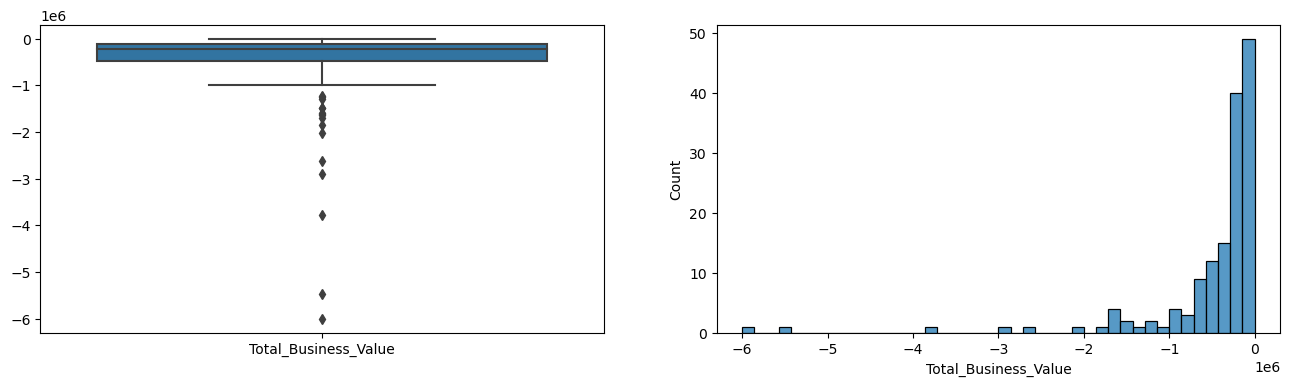

In [419]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(pd.DataFrame(ser_neg_biz_value), ax=axs[0])
sns.histplot(ser_neg_biz_value, ax=axs[1])
plt.show()

In [867]:
for x in range(11):
    print(f'{round(0.01*x, 2)} percentile of Total_Business_Value (only Negative values): {ser_neg_biz_value.quantile(0.01*x)}')

0.0 percentile of Total_Business_Value (only Negative values): -6000000.0
0.01 percentile of Total_Business_Value (only Negative values): -4671422.8
0.02 percentile of Total_Business_Value (only Negative values): -2945307.6
0.03 percentile of Total_Business_Value (only Negative values): -2360097.6000000006
0.04 percentile of Total_Business_Value (only Negative values): -1863459.2
0.05 percentile of Total_Business_Value (only Negative values): -1674386.0
0.06 percentile of Total_Business_Value (only Negative values): -1610805.6
0.07 percentile of Total_Business_Value (only Negative values): -1556566.7999999998
0.08 percentile of Total_Business_Value (only Negative values): -1480933.6
0.09 percentile of Total_Business_Value (only Negative values): -1285633.6
0.1 percentile of Total_Business_Value (only Negative values): -1235492.0


### **Total_Business_Value: Positive Values**

In [421]:
ser_pos_biz_value = df.loc[(df['Total_Business_Value']>=0), 'Total_Business_Value']
ser_pos_biz_value.describe()

count    1.895500e+04
mean     5.800267e+05
std      1.126348e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.500000e+05
75%      7.005350e+05
max      3.374772e+07
Name: Total_Business_Value, dtype: float64

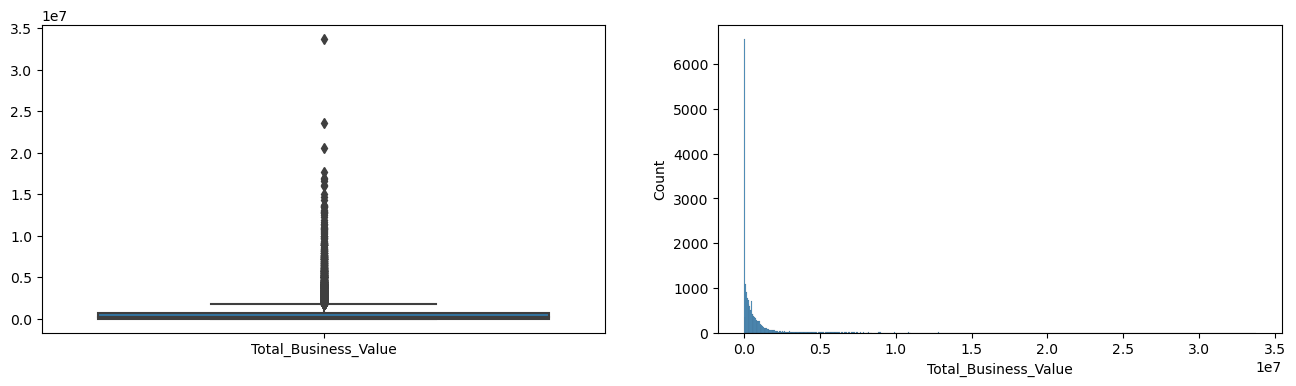

In [422]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(pd.DataFrame(ser_pos_biz_value), ax=axs[0])
sns.histplot(ser_pos_biz_value, ax=axs[1])
plt.show()

In [423]:
for x in range(11):
    print(f'{round(0.9 + 0.01*x, 2)} percentile of Total_Business_Value (only Negative values): {ser_pos_biz_value.quantile(0.9 + 0.01*x)}')

0.9 percentile of Total_Business_Value (only Negative values): 1400050.0
0.91 percentile of Total_Business_Value (only Negative values): 1500000.0
0.92 percentile of Total_Business_Value (only Negative values): 1615134.4
0.93 percentile of Total_Business_Value (only Negative values): 1771748.6000000031
0.94 percentile of Total_Business_Value (only Negative values): 1959249.5999999996
0.95 percentile of Total_Business_Value (only Negative values): 2155493.999999999
0.96 percentile of Total_Business_Value (only Negative values): 2509502.0
0.97 percentile of Total_Business_Value (only Negative values): 2927917.000000003
0.98 percentile of Total_Business_Value (only Negative values): 3508845.199999998
0.99 percentile of Total_Business_Value (only Negative values): 5196451.399999998
1.0 percentile of Total_Business_Value (only Negative values): 33747720.0


In [868]:
# Capping outliers
tot_biz_neg_2p = ser_neg_biz_value.quantile(0.02)
tot_biz_pos_98p = ser_pos_biz_value.quantile(0.98)

In [425]:
df.loc[df['Total_Business_Value']<tot_biz_neg_2p, 'Total_Business_Value'] = tot_biz_neg_2p
df.loc[df['Total_Business_Value']>tot_biz_pos_98p, 'Total_Business_Value'] = tot_biz_pos_98p

In [426]:
df['Total_Business_Value'].describe()

count    1.910400e+04
mean     5.164759e+05
std      7.518455e+05
min     -2.945308e+06
25%      0.000000e+00
50%      2.500000e+05
75%      6.997000e+05
max      3.508845e+06
Name: Total_Business_Value, dtype: float64

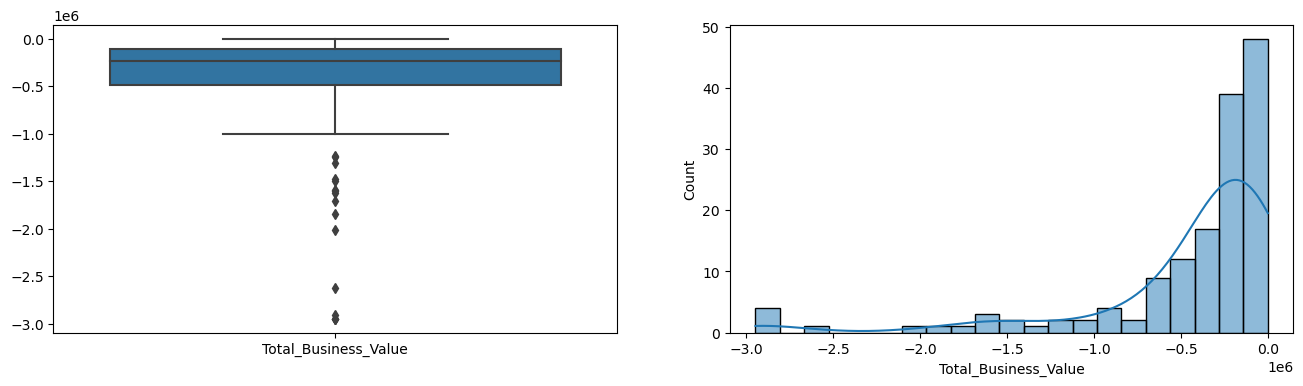

In [869]:
# Distribution of Negative Total_Business_Value
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(pd.DataFrame(df.loc[df['Total_Business_Value']<0, 'Total_Business_Value']), ax=axs[0])
sns.histplot(df.loc[df['Total_Business_Value']<0, 'Total_Business_Value'], ax=axs[1], kde=True)
plt.show()

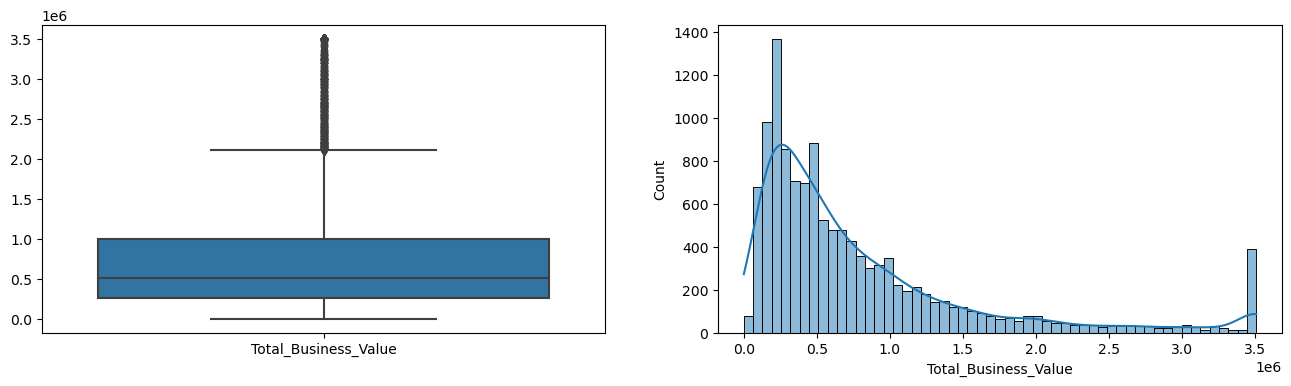

In [870]:
# Distribution of Positive Total_Business_Value
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(pd.DataFrame(df.loc[df['Total_Business_Value']>0, 'Total_Business_Value']), ax=axs[0])
sns.histplot(df.loc[df['Total_Business_Value']>0, 'Total_Business_Value'], ax=axs[1], kde=True)
plt.show()

## **EDA on dynamic columns**

In [429]:
dynamic_cols = ['Income', 'Total_Business_Value', 'Grade', 'Quarterly_Rating']
df[dynamic_cols].describe()

,Income,Total_Business_Value,Grade,Quarterly_Rating
count,19104.000000,1.910400e+04,19104.000000,19104.000000
mean,65652.025126,5.164759e+05,2.252670,2.008899
std,30914.515344,7.518455e+05,1.026512,1.009832
min,10747.000000,-2.945308e+06,1.000000,1.000000
25%,42383.000000,0.000000e+00,1.000000,1.000000
50%,60087.000000,2.500000e+05,2.000000,2.000000
75%,83969.000000,6.997000e+05,3.000000,3.000000
max,188418.000000,3.508845e+06,5.000000,4.000000


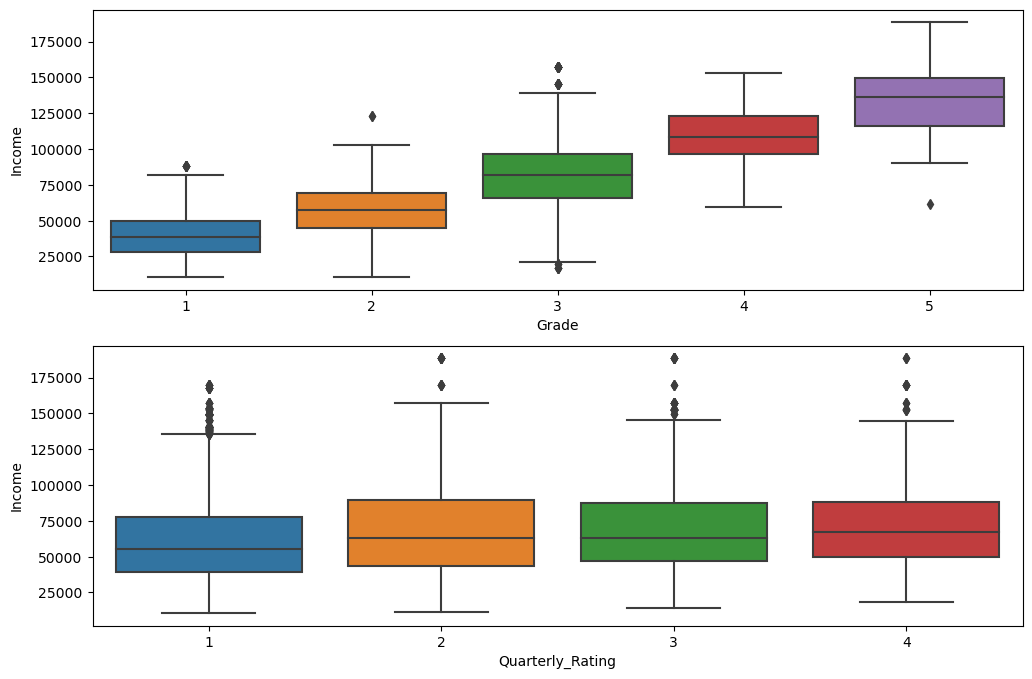

In [430]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

i = 0
for col in ['Grade', 'Quarterly_Rating']:
    sns.boxplot(data=df, x=col, y='Income', ax=axs[i]) 
    if col=='Age':
        axs[i].tick_params(axis='x', rotation=90)
    i += 1

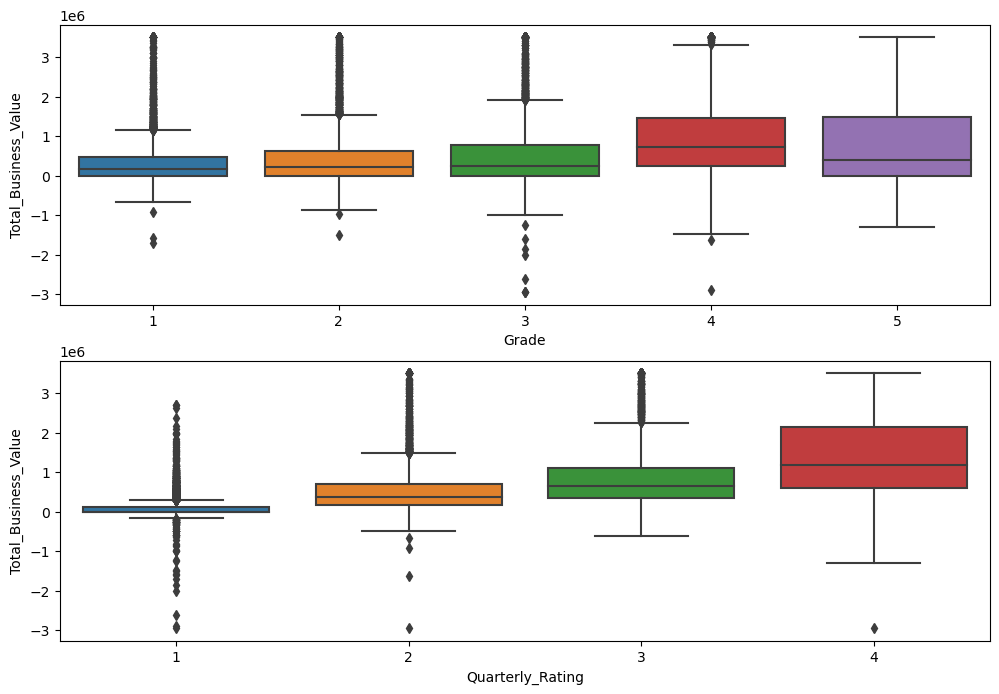

In [431]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

i = 0
for col in ['Grade', 'Quarterly_Rating']:
    sns.boxplot(data=df, x=col, y='Total_Business_Value', ax=axs[i]) 
    if col=='Age':
        axs[i].tick_params(axis='x', rotation=90)
    i += 1

Observations: 
- Median income value & median total_business_values across grades are positively correlated
- Median income value & median total_business_values across Quarterly_Rating are also positively correlated

## **Approach for Aggregation**

For eah driver we will preserve the following values for each column
- Gender: last
- Age: Last
- Education_Level: last
- City: last
- Join_Date: last
- Joining_Designation: last
- MoS: last
- Reporting_Date: count
- Income: [Last, First]
- Total_Business_Value : Sum
- Grade : [Last, First]
- Quarterly_Rating : [Last & Mean]

In [432]:
agg_fuc_dict = { 
    'Gender': 'last',
    'Age' : 'last',
    'Education_Level' : 'last',
    'City' : 'last',
    'Join_Date' : 'last',
    'Joining_Designation' : 'last',
    'MoS' : 'last',
    'Reporting_Date' : 'count',
    'Income' : ['last', 'first'],
    'Total_Business_Value' : ['last', 'mean'],
    'Grade' : ['last', 'first'],
    'Quarterly_Rating' : ['last', 'mean'],
    'Churn' : 'last'
}


df_agg = df.groupby('Driver_ID').agg(agg_fuc_dict)
df_agg.columns = [('_').join(tup) for tup in df_agg.columns]
df_agg.rename(columns = {'Gender_last' : 'Gender',
                         'Age_last' : 'Age',
                         'Education_Level_last' : 'Edu_Lvl',
                         'City_last' : 'City',
                         'Join_Date_last' : 'Join_Date',
                         'Joining_Designation_last' : 'Join_Desig',
                         'MoS_last' : 'MoS',
                         'Reporting_Date_count' : 'Mon_Records',
                         #'Total_Business_Value_mean' : 'Tot_Biz_Val',
                         'Churn_last' : 'Churn'
                        },
              inplace=True
             )
df_agg.head()

,Gender,Age,Edu_Lvl,City,Join_Date,Join_Desig,MoS,Mon_Records,Income_last,Income_first,Total_Business_Value_last,Total_Business_Value_mean,Grade_last,Grade_first,Quarterly_Rating_last,Quarterly_Rating_mean,Churn
Driver_ID,,,,,,,,,,,,,,,,,
1,0.0,28.0,2,C23,2018-12-01,1,4.0,3,57387,57387,0.0,571860.0,1,1,2,2.0,1
2,0.0,31.0,2,C7,2020-11-01,2,2.0,2,67016,67016,0.0,0.0,2,2,1,1.0,0
4,0.0,43.0,2,C13,2019-12-01,2,5.0,5,65603,65603,0.0,70000.0,2,2,1,1.0,1
5,0.0,29.0,0,C9,2019-01-01,1,3.0,3,46368,46368,0.0,40120.0,1,1,1,1.0,1
6,1.0,31.0,1,C11,2020-07-01,3,6.0,5,78728,78728,0.0,253000.0,3,3,2,1.6,0


### **Creating the below features to capture essence of dynamic features**

- Income_incr_flag: 0 if income is same, 1 if income has increased in the 2 year window across which the dataset is based on
- Grade_Upgrade: 0 if grade is not updraded, 1 if grade is upgraded (ruled out that grade did not decrease for any driver)
- Recent_BizVal_Trend : (+)ve if Last Month's Businees Value > Mean Business Value, else (-)ve
- Recent_Rating_Trend : (+)ve if Last Month's Trend > Mean Trend, else (-)ve
- Low_Biz_Val_Mon_Pct : #Months where Business_Value<=0 reported as a % of total months reported
- Low_Rating_Mon_Pct : #Months where Rating=Lowest_Rating(1) reported as a % of total months reported

In [434]:
# df_agg['Income_incr_norm'] = ((df_agg['Income_last']-df_agg['Income_first'])/df_agg['Mon_Records'])
df_agg['Income_incr_flag'] = (df_agg['Income_last']-df_agg['Income_first']).apply(lambda x: 1 if x>0 else 0)
df_agg['Grade_Upgrade'] = df_agg['Grade_last']-df_agg['Grade_first']
df_agg['Recent_BizVal_Trend'] = df_agg['Total_Business_Value_last']-df_agg['Total_Business_Value_mean']
# df_agg['Recent_BizVal_Trend'] = round((df_agg['Total_Business_Value_last']/(df_agg['Total_Business_Value_mean']+1)-1), 3)
df_agg['Recent_Rating_Trend'] = df_agg['Quarterly_Rating_last']-df_agg['Quarterly_Rating_mean']


df_agg.head()

,Gender,Age,Edu_Lvl,City,Join_Date,Join_Desig,MoS,Mon_Records,Income_last,Income_first,...,Total_Business_Value_mean,Grade_last,Grade_first,Quarterly_Rating_last,Quarterly_Rating_mean,Churn,Income_incr_flag,Grade_Upgrade,Recent_BizVal_Trend,Recent_Rating_Trend
Driver_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,28.0,2,C23,2018-12-01,1,4.0,3,57387,57387,...,571860.0,1,1,2,2.0,1,0,0,-571860.0,0.0
2,0.0,31.0,2,C7,2020-11-01,2,2.0,2,67016,67016,...,0.0,2,2,1,1.0,0,0,0,0.0,0.0
4,0.0,43.0,2,C13,2019-12-01,2,5.0,5,65603,65603,...,70000.0,2,2,1,1.0,1,0,0,-70000.0,0.0
5,0.0,29.0,0,C9,2019-01-01,1,3.0,3,46368,46368,...,40120.0,1,1,1,1.0,1,0,0,-40120.0,0.0
6,1.0,31.0,1,C11,2020-07-01,3,6.0,5,78728,78728,...,253000.0,3,3,2,1.6,0,0,0,-253000.0,0.4


In [437]:
# df_x = df.copy()
# df_x['row_num'] = df.sort_values(by='Reporting_Date', ascending=False).groupby('Driver_ID').cumcount()+1

In [438]:
# df_x.loc[df_x['Driver_ID']==2000]
# df_x.loc[df_x['Driver_ID']==5]

In [439]:
df_cnt_mon_neg_biz_val = df.groupby('Driver_ID')[['Total_Business_Value']].apply(lambda x: (x<=0).sum())
df_cnt_mon_neg_biz_val.rename(columns={'Total_Business_Value' : 'Low_Biz_Val_Mon_Cnt'}, inplace=True)
df_cnt_mon_neg_biz_val.head()

,Low_Biz_Val_Mon_Cnt
Driver_ID,
1,2
2,2
4,4
5,2
6,4


In [440]:
df_agg1 = pd.merge(df_agg, df_cnt_mon_neg_biz_val, left_index=True, right_index=True)
df_agg1['Low_Biz_Val_Mon_Pct'] = round(df_agg1['Low_Biz_Val_Mon_Cnt']/df_agg1['Mon_Records'], 3)
df_agg1.head()

,Gender,Age,Edu_Lvl,City,Join_Date,Join_Desig,MoS,Mon_Records,Income_last,Income_first,...,Grade_first,Quarterly_Rating_last,Quarterly_Rating_mean,Churn,Income_incr_flag,Grade_Upgrade,Recent_BizVal_Trend,Recent_Rating_Trend,Low_Biz_Val_Mon_Cnt,Low_Biz_Val_Mon_Pct
Driver_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,28.0,2,C23,2018-12-01,1,4.0,3,57387,57387,...,1,2,2.0,1,0,0,-571860.0,0.0,2,0.667
2,0.0,31.0,2,C7,2020-11-01,2,2.0,2,67016,67016,...,2,1,1.0,0,0,0,0.0,0.0,2,1.000
4,0.0,43.0,2,C13,2019-12-01,2,5.0,5,65603,65603,...,2,1,1.0,1,0,0,-70000.0,0.0,4,0.800
5,0.0,29.0,0,C9,2019-01-01,1,3.0,3,46368,46368,...,1,1,1.0,1,0,0,-40120.0,0.0,2,0.667
6,1.0,31.0,1,C11,2020-07-01,3,6.0,5,78728,78728,...,3,2,1.6,0,0,0,-253000.0,0.4,4,0.800


In [441]:
df_cnt_mon_low_rating = df.groupby('Driver_ID')[['Grade']].apply(lambda x: (x<2).sum())
df_cnt_mon_low_rating.rename(columns={'Grade' : 'Low_Rating_Mon_Cnt'}, inplace=True)
df_cnt_mon_low_rating.head()

,Low_Rating_Mon_Cnt
Driver_ID,
1,3
2,0
4,0
5,3
6,0


In [442]:
df_agg2 = pd.merge(df_agg1, df_cnt_mon_low_rating, left_index=True, right_index=True)
df_agg2['Low_Rating_Mon_Pct'] = round(df_agg2['Low_Rating_Mon_Cnt']/df_agg2['Mon_Records'], 3)
df_agg2.head()

,Gender,Age,Edu_Lvl,City,Join_Date,Join_Desig,MoS,Mon_Records,Income_last,Income_first,...,Quarterly_Rating_mean,Churn,Income_incr_flag,Grade_Upgrade,Recent_BizVal_Trend,Recent_Rating_Trend,Low_Biz_Val_Mon_Cnt,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Cnt,Low_Rating_Mon_Pct
Driver_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,28.0,2,C23,2018-12-01,1,4.0,3,57387,57387,...,2.0,1,0,0,-571860.0,0.0,2,0.667,3,1.0
2,0.0,31.0,2,C7,2020-11-01,2,2.0,2,67016,67016,...,1.0,0,0,0,0.0,0.0,2,1.000,0,0.0
4,0.0,43.0,2,C13,2019-12-01,2,5.0,5,65603,65603,...,1.0,1,0,0,-70000.0,0.0,4,0.800,0,0.0
5,0.0,29.0,0,C9,2019-01-01,1,3.0,3,46368,46368,...,1.0,1,0,0,-40120.0,0.0,2,0.667,3,1.0
6,1.0,31.0,1,C11,2020-07-01,3,6.0,5,78728,78728,...,1.6,0,0,0,-253000.0,0.4,4,0.800,0,0.0


In [871]:
# Compiling final dataset after aggregation
df_agg_final = df_agg2.copy()
df_agg_final['Join_Year'] = df_agg_final['Join_Date'].dt.year
# df_agg_final['Join_Month'] = df_agg_final['Join_Date'].dt.month
df_agg_final.drop(['Income_first', 'Grade_first', 'Total_Business_Value_last', 'Low_Biz_Val_Mon_Cnt', 'Low_Rating_Mon_Cnt'], axis=1, inplace=True)
df_agg_final.rename(columns={'Income_last' : 'Income',
                             'Grade_last' : 'Grade',
                             'Quarterly_Rating_last' : 'Rtng',
                             'Quarterly_Rating_mean' : 'Mean_Rtng',
                             'Total_Business_Value_mean' : 'Mean_Biz_Val',
                             'Recent_BizVal_Trend' : 'Trend_BizVal',
                             'Recent_Rating_Trend' : 'Trend_Rtng'
                            },
                    inplace=True
                   )
df_agg_final
df_agg_final = df_agg_final[['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 'Mon_Records',
                             'Income', 'Income_incr_flag', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Trend_Rtng',
                             'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct', 'Churn'
                            ]]
df_agg_final.reset_index(inplace=True)
df_agg_final.head()

,Driver_ID,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Mon_Records,Income,...,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct,Churn
0,1,0.0,28.0,2,C23,2018,1,4.0,3,57387,...,1,0,2,2.0,0.0,571860.0,-571860.0,0.667,1.0,1
1,2,0.0,31.0,2,C7,2020,2,2.0,2,67016,...,2,0,1,1.0,0.0,0.0,0.0,1.000,0.0,0
2,4,0.0,43.0,2,C13,2019,2,5.0,5,65603,...,2,0,1,1.0,0.0,70000.0,-70000.0,0.800,0.0,1
3,5,0.0,29.0,0,C9,2019,1,3.0,3,46368,...,1,0,1,1.0,0.0,40120.0,-40120.0,0.667,1.0,1
4,6,1.0,31.0,1,C11,2020,3,6.0,5,78728,...,3,0,2,1.6,0.4,253000.0,-253000.0,0.800,0.0,0


# **EDA**

## **Univariate Analysis**

In [444]:
for col in df_agg_final.columns[1:-1]:
    print(f'#Unique values in {col}: {df_agg_final[col].nunique()}')

#Unique values in Gender: 2
#Unique values in Age: 36
#Unique values in Edu_Lvl: 3
#Unique values in City: 29
#Unique values in Join_Year: 8
#Unique values in Join_Desig: 5
#Unique values in MoS: 92
#Unique values in Mon_Records: 24
#Unique values in Income: 2339
#Unique values in Income_incr_flag: 2
#Unique values in Grade: 5
#Unique values in Grade_Upgrade: 2
#Unique values in Rtng: 4
#Unique values in Mean_Rtng: 163
#Unique values in Trend_Rtng: 211
#Unique values in Mean_Biz_Val: 1639
#Unique values in Trend_BizVal: 1646
#Unique values in Low_Biz_Val_Mon_Pct: 102
#Unique values in Low_Rating_Mon_Pct: 7


In [872]:
# Splitting columns in Categorical & Numerical Columns
cat_cols = ['Gender', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'Grade', 'Grade_Upgrade', 'Rtng', 'Income_incr_flag']
num_cols = [col for col in df_agg_final.columns[1:-1] if col not in cat_cols]
print(f'Categorical Columns: {cat_cols}')
print(f'Numerical Columns: {num_cols}')

Categorical Columns: ['Gender', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'Grade', 'Grade_Upgrade', 'Rtng', 'Income_incr_flag']
Numerical Columns: ['Age', 'MoS', 'Mon_Records', 'Income', 'Mean_Rtng', 'Trend_Rtng', 'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct']


In [446]:
len(cat_cols)

9

In [447]:
len(num_cols)

10

### **Target variable is imbalanced**

In [448]:
df_agg_final2 = df_agg_final.copy()
df_agg_final['Churn'] = df_agg_final['Churn'].astype(str)

In [875]:
print('Absolute Counts')
print(df_agg_final['Churn'].value_counts())
print('-'*60)
print('Normalized')
print(df_agg_final['Churn'].value_counts(normalize=True))

Absolute Counts
1    1616
0     765
Name: Churn, dtype: int64
------------------------------------------------------------
Normalized
1    0.678706
0    0.321294
Name: Churn, dtype: float64


### **Categorical columns**

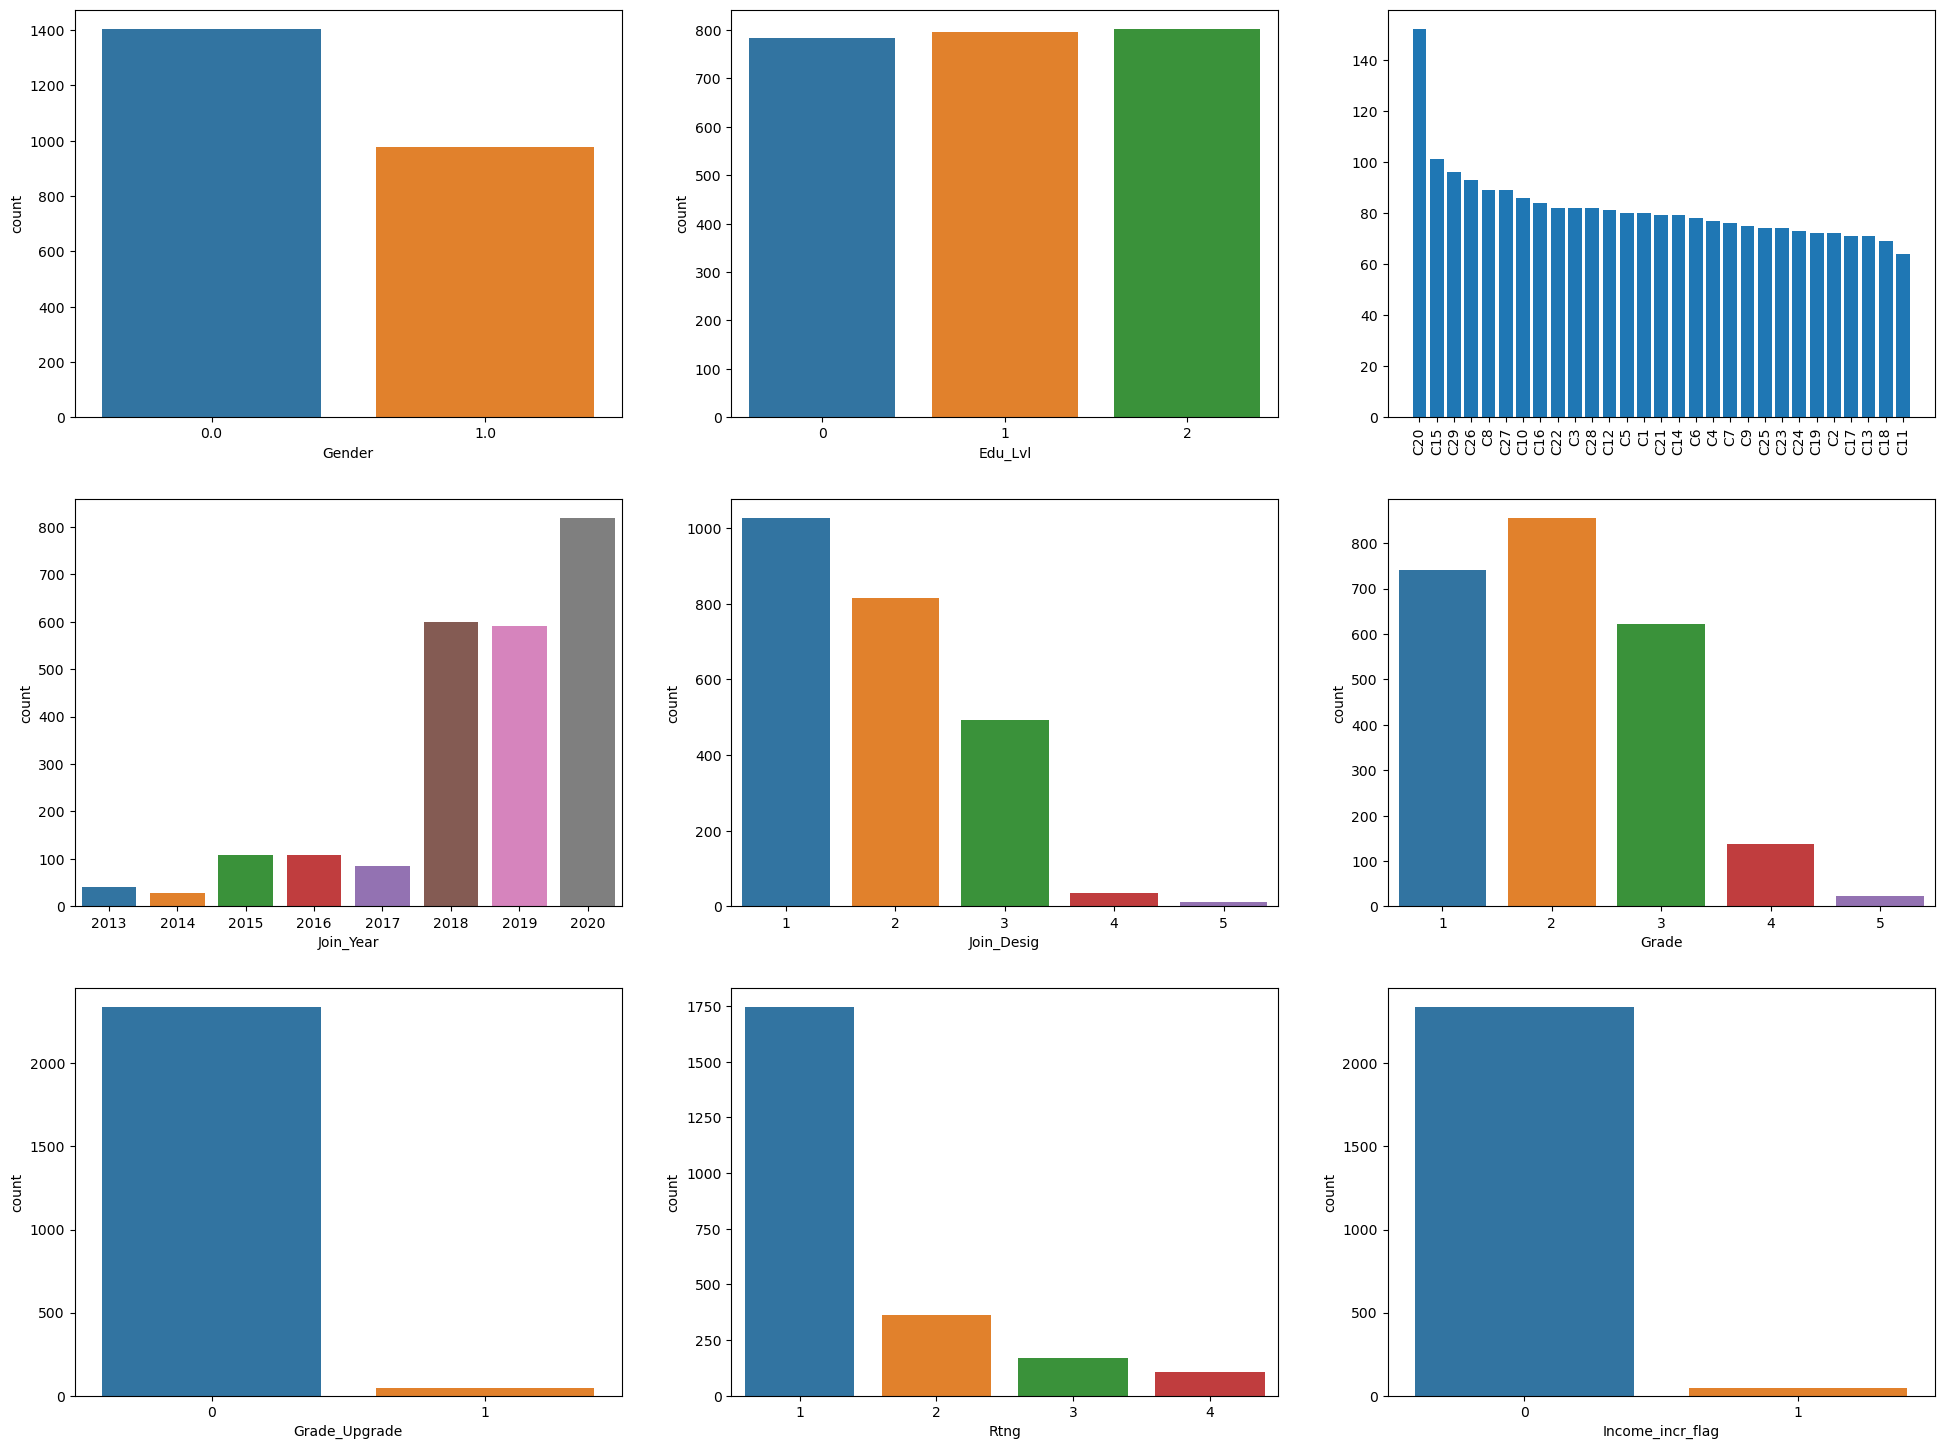

In [449]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

i = 0
for col in cat_cols[:3]:
    if col == 'City':
        axs[0][i].bar(df_agg_final[col].value_counts().index, df_agg_final[col].value_counts().values)
        axs[0][i].tick_params(axis='x', rotation=90)
    else:
        sns.countplot(data=df_agg_final, x=col, ax=axs[0][i])
    i += 1 
    
i = 0
for col in cat_cols[3:6]:
    sns.countplot(data=df_agg_final, x=col, ax=axs[1][i])
    i += 1 
    
i = 0
for col in cat_cols[6:]:
    sns.countplot(data=df_agg_final, x=col, ax=axs[2][i])
    i += 1 
    
plt.show()

**Observations:**
- Male drivers (0) more than female drivers (1)
- City20 (C20) has the majority of drivers
- Most drivers joining Ola in recent years (2018 onwards)
- Most drivers join Ola at Designation=1
- Grade=2 is the most common grade drivers are in
- The latest reported quarterly rating of most drivers is low (1)
- Only a handful of drivers have received income increment (income increment tallys with grade increment)

### **Numerical columns**

In [450]:
df_agg_final[num_cols].describe()

,Age,MoS,Mon_Records,Income,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2.381000e+03,2381.000000,2381.000000
mean,33.663167,15.190256,8.02352,59334.157077,1.566304,-0.138333,2.875559e+05,-6.131592e+04,0.564581,0.314892
std,5.983375,18.581761,6.78359,28383.666384,0.719652,0.552101,3.669335e+05,3.986078e+05,0.354310,0.464103
min,21.000000,1.000000,1.00000,10747.000000,1.000000,-2.727273,-1.979329e+05,-2.271998e+06,0.000000,0.000000
25%,29.000000,4.000000,3.00000,39104.000000,1.000000,-0.333333,0.000000e+00,-2.199733e+05,0.250000,0.000000
50%,33.000000,7.000000,5.00000,55315.000000,1.000000,0.000000,1.506244e+05,-1.876167e+04,0.500000,0.000000
75%,37.000000,17.000000,10.00000,75986.000000,2.000000,0.000000,4.294988e+05,0.000000e+00,1.000000,1.000000
max,58.000000,93.000000,24.00000,188418.000000,4.000000,2.052632,2.325064e+06,2.585489e+06,1.000000,1.000000


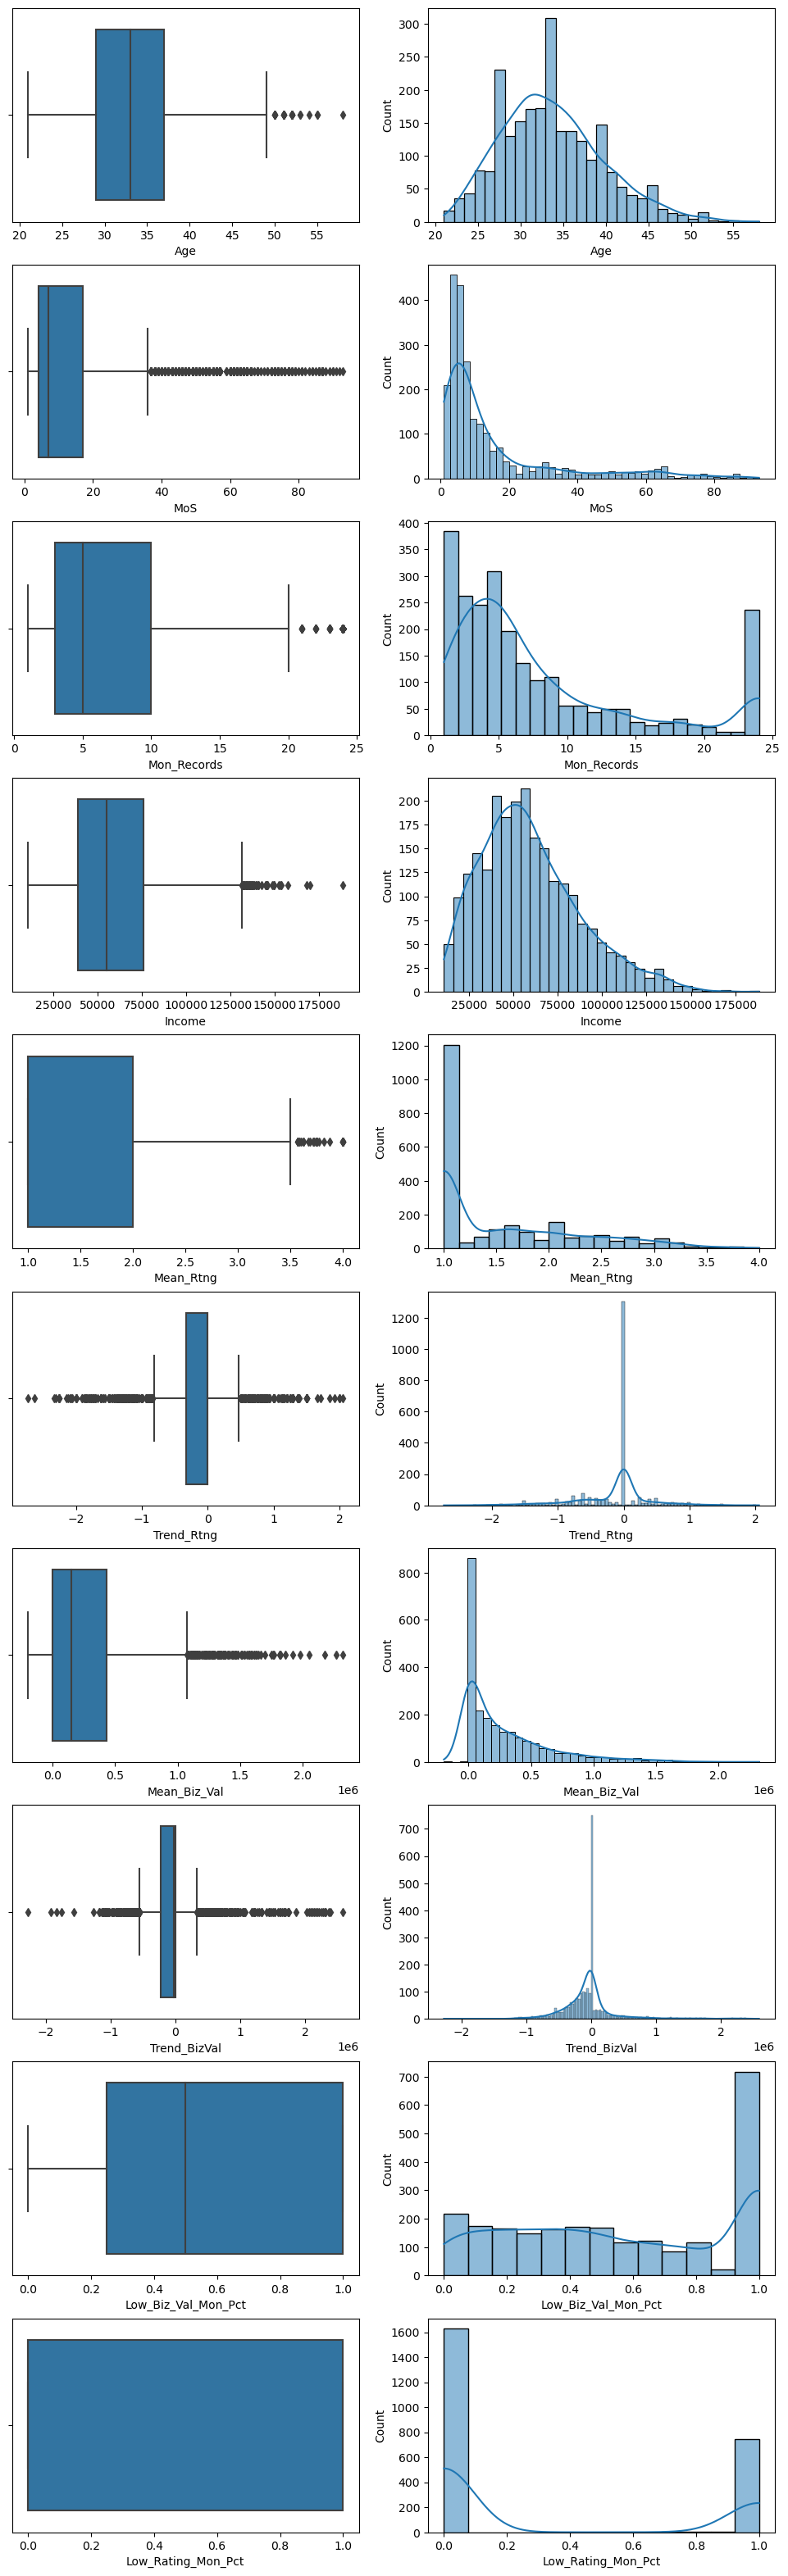

In [451]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(12, 40))

i = 0
for col in num_cols:
    j = 0
    sns.boxplot(data=df_agg_final, x=col, ax=axs[i][j])
    sns.histplot(data=df_agg_final, x=col, ax=axs[i][j+1], kde=True)
    i += 1
 
plt.show()

**Observations:**
- MoS (Months of Service) is a right skewed distribution. This makes sense since we saw many drivers joined Ola in recent years
- Most drivers are in the age bracket of 30-35
- Most common monthly income values are b/w 40k-75k
- Mean_Biz_Value is a right skewed distribution

## **Bivariate Analysis**

### **Categorical Columns**

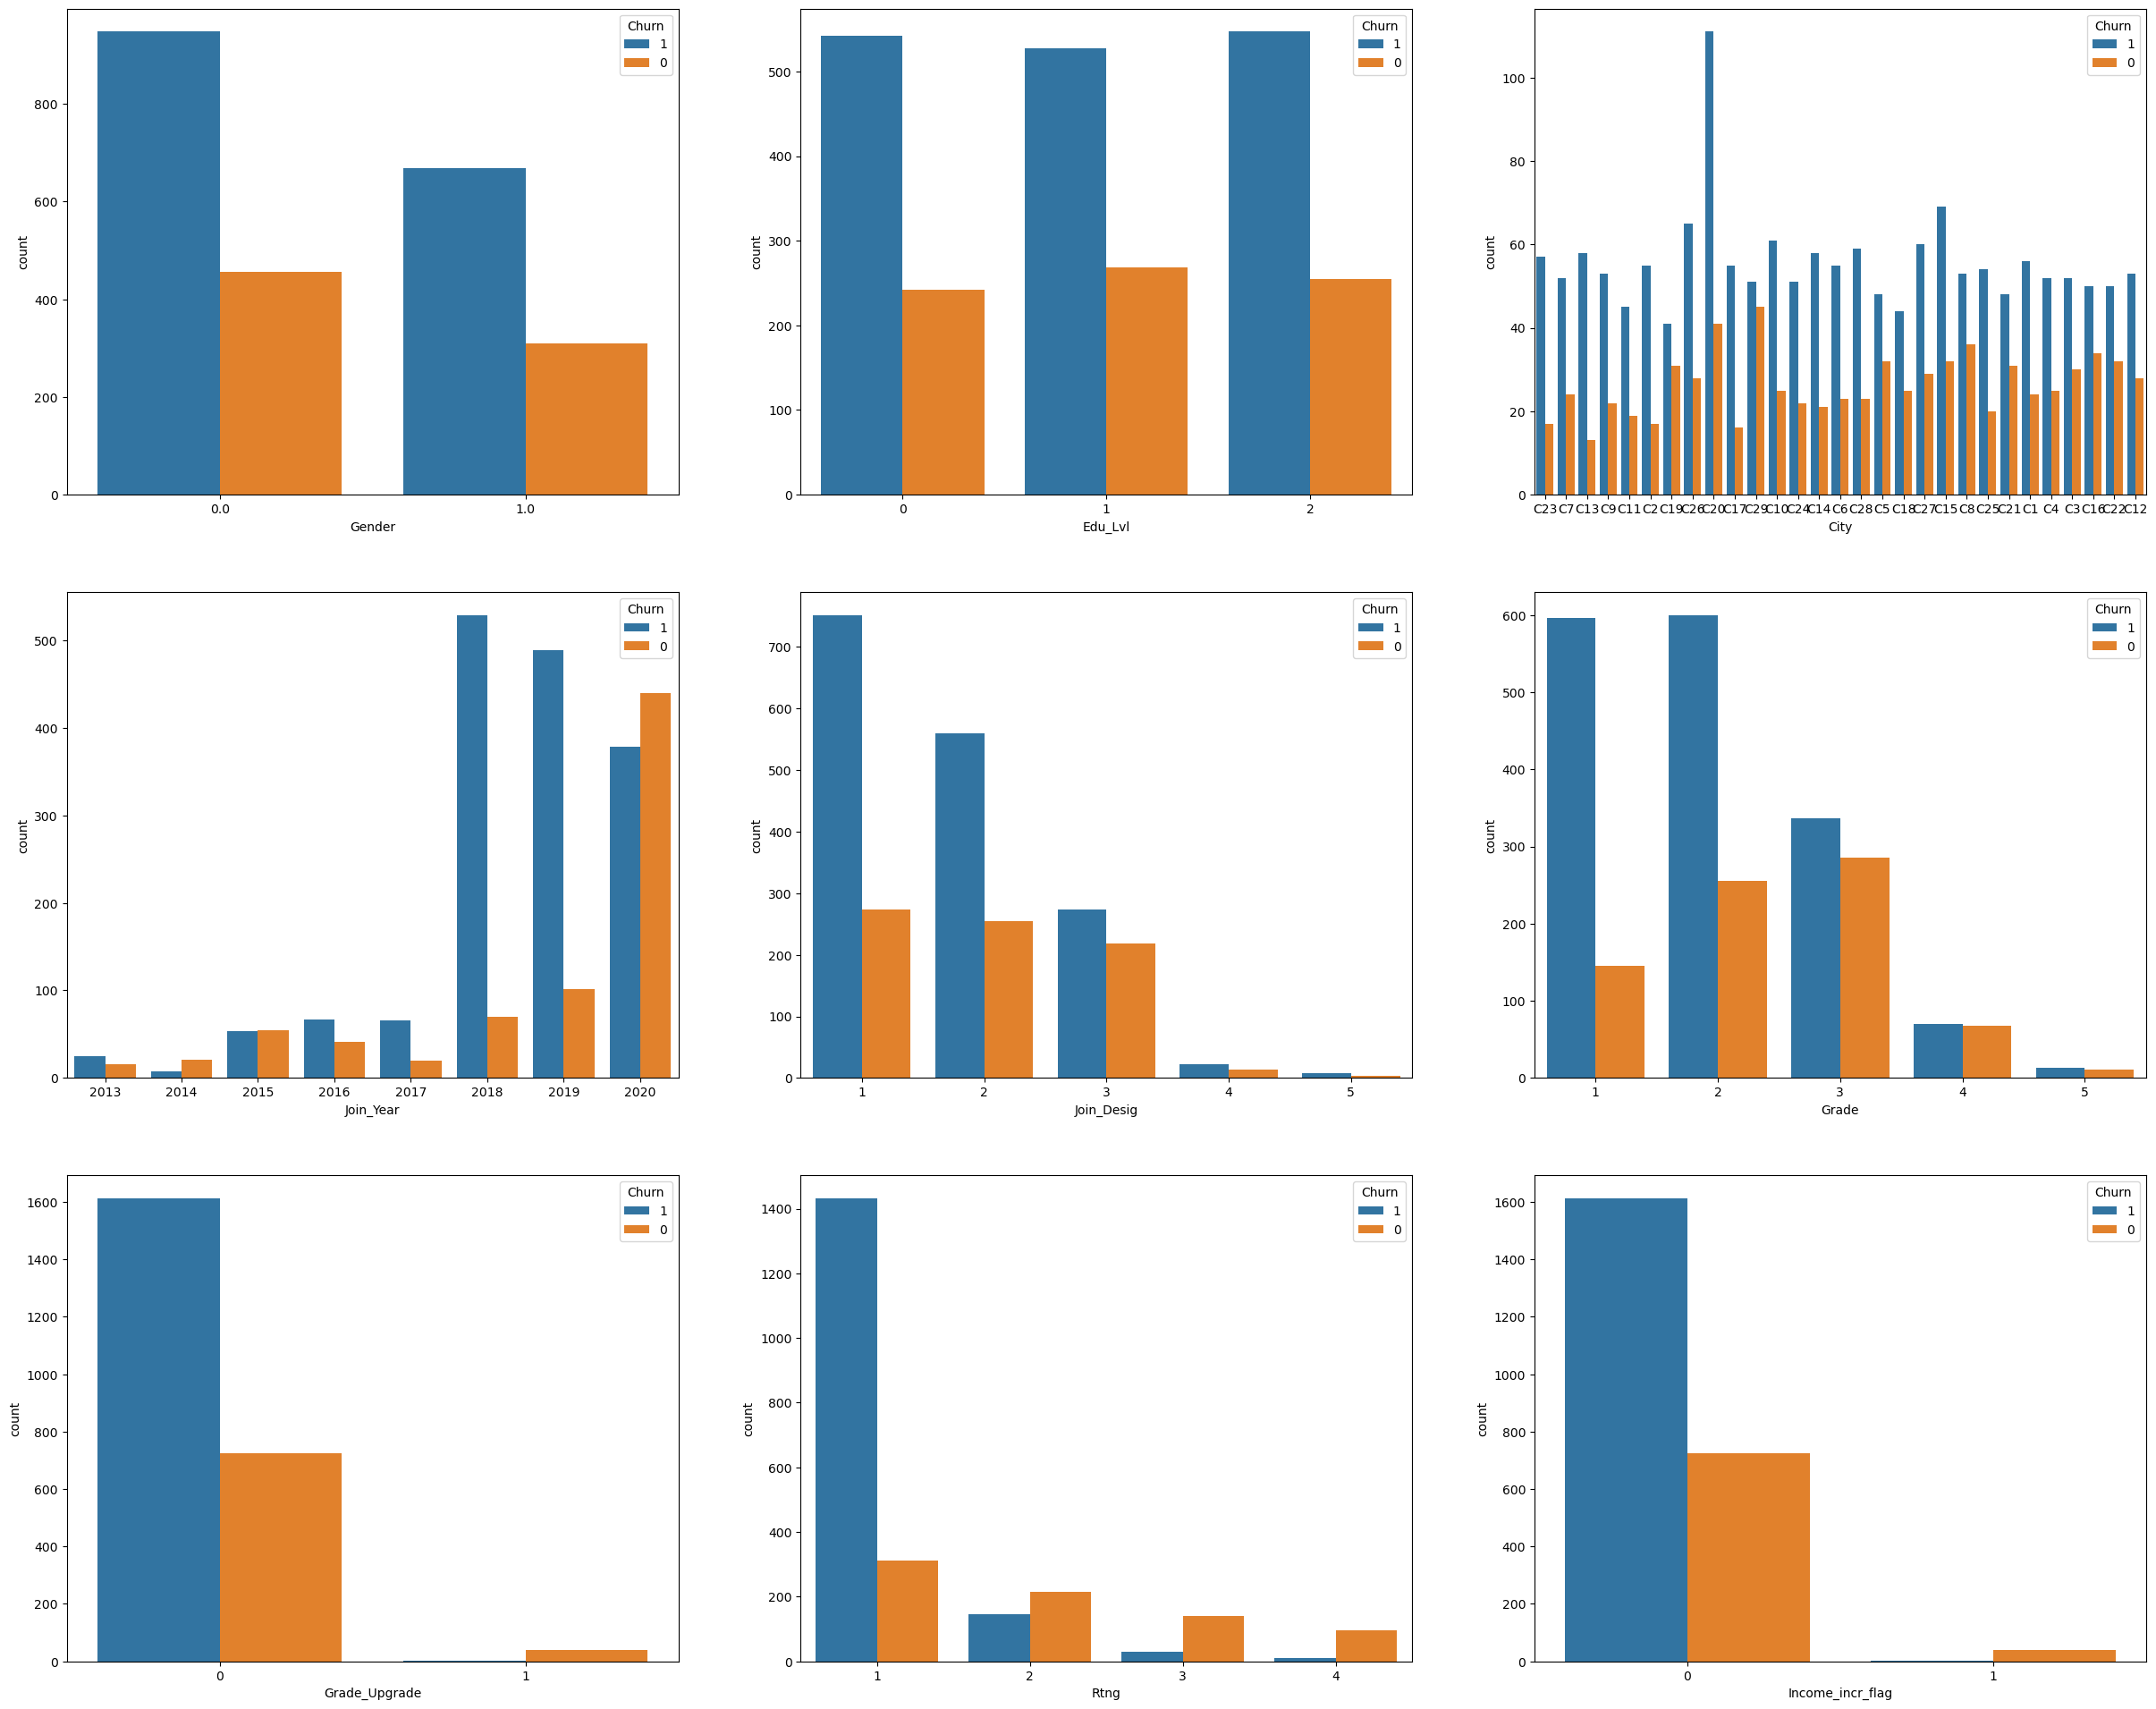

In [452]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 24))

i = 0
for col in cat_cols[:3]:
    # if col == 'City':
    #     axs[0][i].bar(df_agg_final[col].value_counts().index, df_agg_final[col].value_counts().values)
    #     axs[0][i].tick_params(axis='x', rotation=90)
    # else:
    #     sns.countplot(data=df_agg_final, x=col, ax=axs[0][i], hue='Churn')
    sns.countplot(data=df_agg_final, x=col, ax=axs[0][i], hue='Churn')
    i += 1 
    
i = 0
for col in cat_cols[3:6]:
    sns.countplot(data=df_agg_final, x=col, ax=axs[1][i], hue='Churn')
    i += 1 
    
i = 0
for col in cat_cols[6:]:
    sns.countplot(data=df_agg_final, x=col, ax=axs[2][i], hue='Churn')
    i += 1 
    
plt.show()

**Observations:**

- Grade_Upgrade and Income_incr_flag are looking very similar when it comes to affecting churn (we will only consider one of these 2 in our model)
- Important variables which seem to impact churn
    - City
    - Join_Year
    - Join_Desig
    - Grade
    - Rtng
    - Grade_Upgrade

### **Numerical Columns**

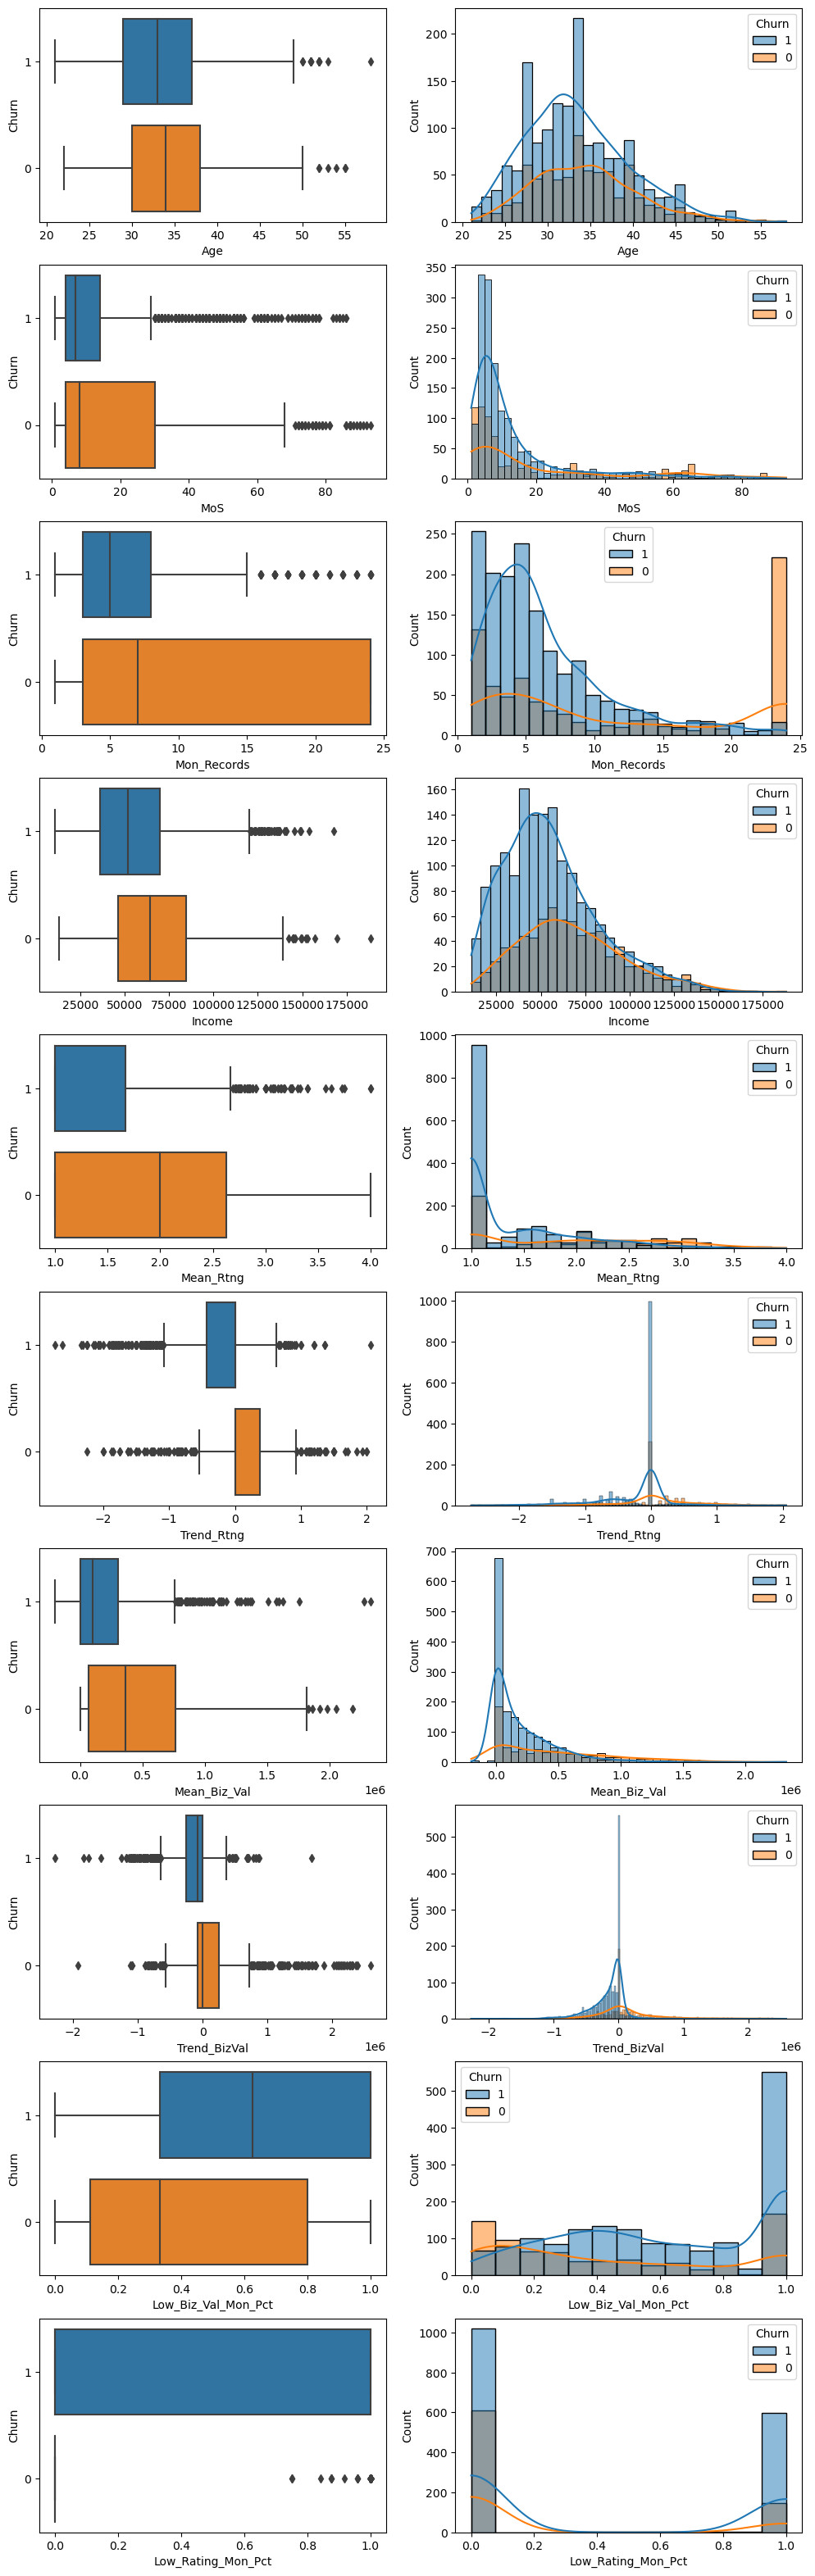

In [453]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(12, 40))

i = 0
for col in num_cols:
    j = 0
    # sns.boxplot(data=df_agg_final, x=col, ax=axs[i][j])
    sns.boxplot(x=df_agg_final[col], y=df_agg_final['Churn'], ax=axs[i][j])
    sns.histplot(data=df_agg_final, x=col, ax=axs[i][j+1], kde=True, hue='Churn')
    i += 1
 
plt.show()

**Observations:**
- MoS (MonthsofService)
- Income
- Mean_Rtng
- Trend_Rtng
- Mean_BizVal
- Trend_BizVal
- Low_Biz_Val_Mon_Pct
- Low_Rating_Mon_Pct

### **Correlation Heatmap**

In [454]:
num_cols_mod = num_cols.copy()
num_cols_mod.append('Churn')

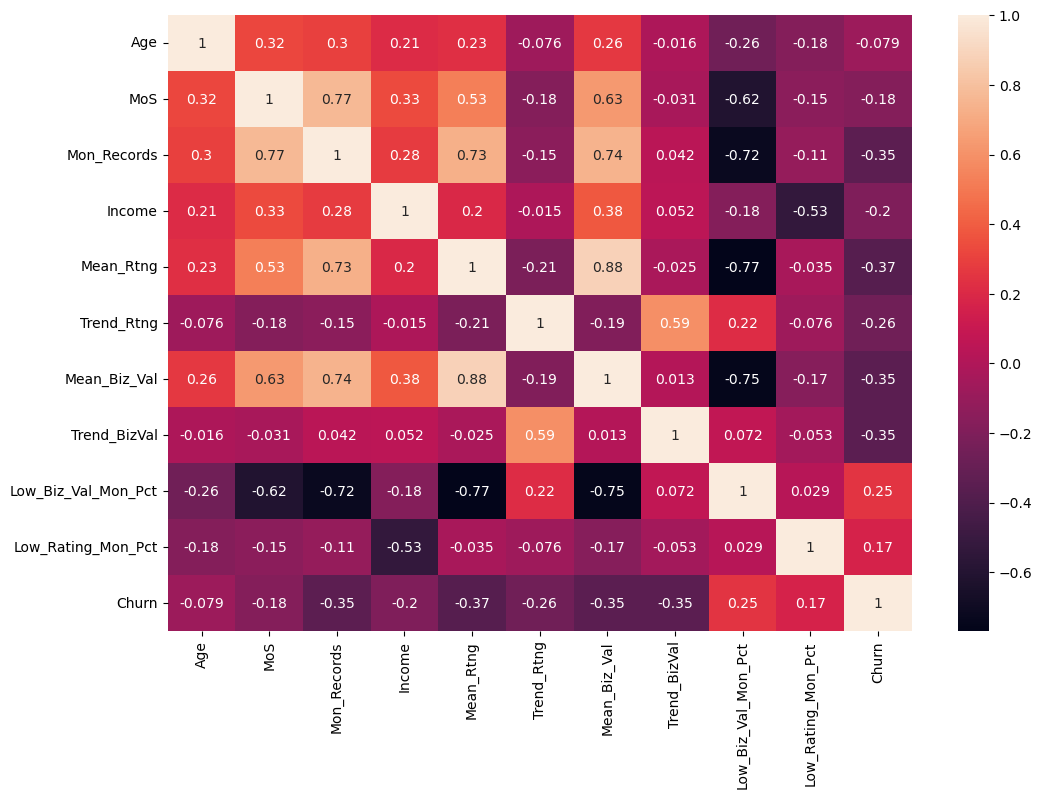

In [464]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_agg_final2[num_cols_mod].corr(), annot=True)
plt.show()

## **Looking for patterns across different cities**

In [490]:
df_inc_biz_val_by_city = df_agg_final2.groupby('City')[['Income', 'Mean_Biz_Val']].median()
df_cnt_no_churn_by_city = df_agg_final2.loc[df_agg_final2['Churn']==0].groupby('City')[['Driver_ID']].count()
df_cnt_no_churn_by_city.rename(columns={'Driver_ID' : 'No_Churn'}, inplace=True)
df_cnt_churn_by_city = df_agg_final2.loc[df_agg_final2['Churn']==1].groupby('City')[['Driver_ID']].count()
df_cnt_churn_by_city.rename(columns={'Driver_ID' : 'Churn'}, inplace=True)

In [498]:
df_by_city = pd.merge(df_inc_biz_val_by_city, df_cnt_no_churn_by_city, left_index=True, right_index=True)
df_by_city = pd.merge(df_by_city, df_cnt_churn_by_city, left_index=True, right_index=True)
df_by_city['No_Churn_Pct'] = df_by_city.apply(lambda x: (100*x[0]/(x[0]+x[1])), axis=1)
df_by_city['Churn_Pct'] = 100-df_by_city['No_Churn_Pct']
df_by_city.sort_values(by='Churn_Pct', ascending=True, inplace=True)
df_by_city.head()

,Income,Mean_Biz_Val,No_Churn,Churn,No_Churn_Pct,Churn_Pct
City,,,,,,
C27,58259.0,96071.666667,29,60,37.749464,62.250536
C5,59521.5,103110.000000,32,48,36.598998,63.401002
C20,58273.0,112908.125000,41,111,34.041720,65.958280
C11,61473.5,122055.000000,19,45,33.495343,66.504657
C15,54695.0,112430.000000,32,69,32.727001,67.272999


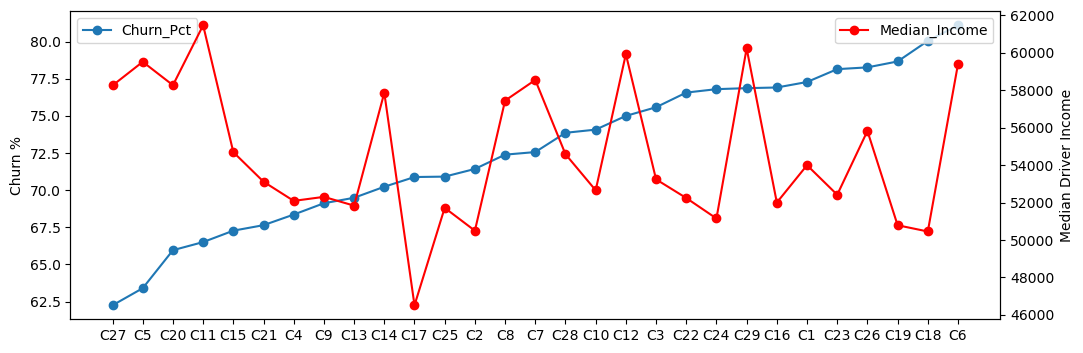

In [662]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df_by_city.index, df_by_city['Churn_Pct'], label='Churn_Pct', marker='o')
ax1.set_ylabel('Churn %')
ax2 = ax1.twinx()
ax2.plot(df_by_city.index, df_by_city['Income'], label='Median_Income', color='red', marker='o')
ax2.set_ylabel('Median Driver Income')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

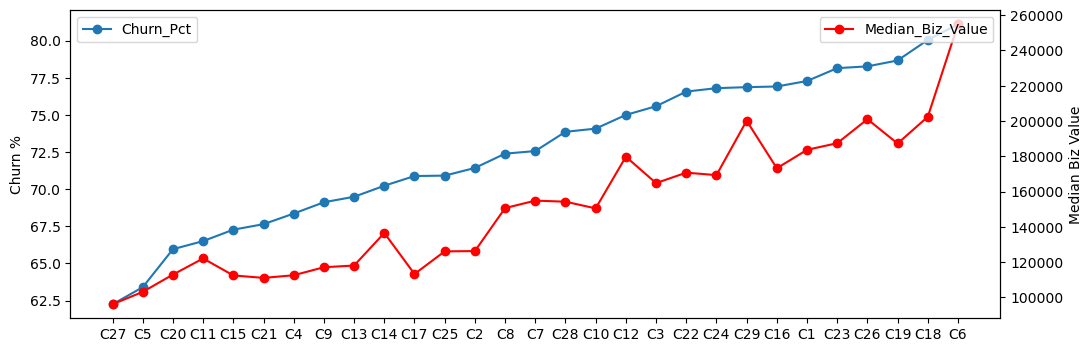

In [663]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df_by_city.index, df_by_city['Churn_Pct'], label='Churn_Pct', marker='o')
ax1.set_ylabel('Churn %')
ax2 = ax1.twinx()
ax2.plot(df_by_city.index, df_by_city['Mean_Biz_Val'], label='Median_Biz_Value', color='red', marker='o')
ax2.set_ylabel('Median Biz Value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

**Observations**
- Churn rate and median income of drivers across city seem to be uncorrelated
- Churn rate and median Biz_Value of drivers across city seem to positively correlated

## **Creating new feature: Tier of Driver within City based of Biz_Value**

In [681]:
df_agg_final3 = df_agg_final2.copy()
df_agg_final3.head()

,Driver_ID,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Mon_Records,Income,...,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct,Churn
0,1,0.0,28.0,2,C23,2018,1,4.0,3,57387,...,1,0,2,2.0,0.0,571860.0,-571860.0,0.667,1.0,1
1,2,0.0,31.0,2,C7,2020,2,2.0,2,67016,...,2,0,1,1.0,0.0,0.0,0.0,1.000,0.0,0
2,4,0.0,43.0,2,C13,2019,2,5.0,5,65603,...,2,0,1,1.0,0.0,70000.0,-70000.0,0.800,0.0,1
3,5,0.0,29.0,0,C9,2019,1,3.0,3,46368,...,1,0,1,1.0,0.0,40120.0,-40120.0,0.667,1.0,1
4,6,1.0,31.0,1,C11,2020,3,6.0,5,78728,...,3,0,2,1.6,0.4,253000.0,-253000.0,0.800,0.0,0


In [732]:
def classify1(bizval, city_median_bizval):
    if bizval>1.75*city_median_bizval:
        return 1
    elif bizval<0.25*city_median_bizval:
        return 3
    return 2

    
df_agg_final3 = df_agg_final2.copy()

    
# df_grp_city_median_bizval = df_agg_final3.groupby('City')[['Mean_Biz_Val']].describe().iloc[:, [4, 5, 6]]
df_grp_city_median_bizval = df_agg_final3.groupby('City')[['Mean_Biz_Val']].describe().iloc[:, [5]]
df_grp_city_median_bizval.columns = [('_').join(tup) for tup in df_grp_city_median_bizval.columns]
df_grp_city_median_bizval.rename(columns={'Mean_Biz_Val_50%' : 'Median_Biz_Val_by_City'}, inplace=True)
# df_grp_city_median_bizval
df_agg_final3 = pd.merge(df_agg_final3, df_grp_city_median_bizval, on='City', how='left')
df_agg_final3['Tier_in_City_Bizval'] = df_agg_final3[['Mean_Biz_Val', 'Median_Biz_Val_by_City']].apply(lambda x: classify1(x[0], x[1]) ,axis=1)
df_agg_final3['Tier_in_City_Bizval'].value_counts()

1    903
3    801
2    677
Name: Tier_in_City_Bizval, dtype: int64

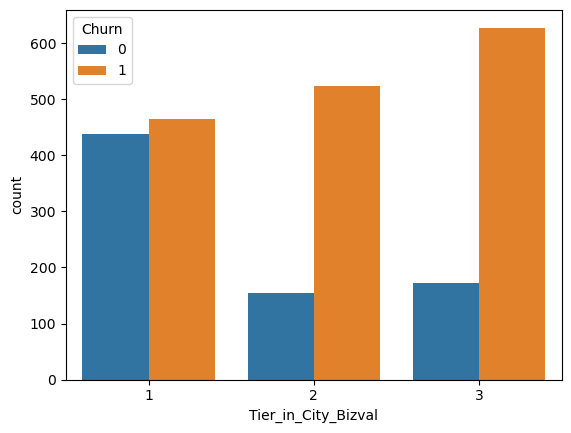

In [873]:
# Churn seems to be more common for drivers with tier=3 which makes intuitive sense
sns.countplot(data=df_agg_final3, x='Tier_in_City_Bizval', hue='Churn')
plt.show()

# **BaseLine Model: Finalising Feature Set to run Final Model on**
- Using a RandomForestClassifier with default parametrs to see performance

## **Trail 1:**
Features used to predict Churn:
- ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Mean_Biz_Val']
- Using 10-fold cross-validation, Mean Accuracy achieved: 86.4%, Stdev:2.9%

In [636]:
feat_set1 = ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 
             'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Mean_Biz_Val', 'Churn']
df_agg_final_ml2_v1 = df_agg_final2[feat_set1].copy()

# Categorical to Numerical
tar_enc = TargetEncoder()
df_agg_final_ml2_v1['City'] = tar_enc.fit_transform(df_agg_final_ml2_v1['City'], df_agg_final_ml2_v1['Churn'])

print('Shape:', df_agg_final_ml2_v1.shape)
df_agg_final_ml2_v1.head()

Shape: (2381, 14)


,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Income,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Mean_Biz_Val,Churn
0,0.0,28.0,2,0.769859,2018,1,4.0,57387,1,0,2,2.0,571860.0,1
1,0.0,31.0,2,0.684190,2020,2,2.0,67016,2,0,1,1.0,0.0,0
2,0.0,43.0,2,0.816064,2019,2,5.0,65603,2,0,1,1.0,70000.0,1
3,0.0,29.0,0,0.706553,2019,1,3.0,46368,1,0,1,1.0,40120.0,1
4,1.0,31.0,1,0.702829,2020,3,6.0,78728,3,0,2,1.6,253000.0,0


In [637]:
# Splitting b/w independent and dependent features
X2_v1 = df_agg_final_ml2_v1.iloc[:, :-1]
y2_v1 = df_agg_final_ml2_v1.iloc[:, -1]

In [638]:
# Train-Test split
X_train2_v1, X_test2_v1, y_train2_v1, y_test2_v1 = train_test_split(X2_v1, y2_v1, test_size=0.2, random_state=42)
print('Shape of Xtrain:', X_train2_v1.shape)
print('Shape of ytrain:', y_train2_v1.shape)
print('Shape of Xtest:', X_test2_v1.shape)
print('Shape of ytest:', y_test2_v1.shape)

Shape of Xtrain: (1904, 13)
Shape of ytrain: (1904,)
Shape of Xtest: (477, 13)
Shape of ytest: (477,)


In [639]:
# Scaling the Data
std_scaler = StandardScaler()
X_train_scaled2_v1 = std_scaler.fit_transform(X_train2_v1)
X_test_scaled2_v1 = std_scaler.transform(X_test2_v1)

In [740]:
rfc1 = RandomForestClassifier(random_state=42)
cross_val_rfc_feat_set1 = cross_val_score(rfc1, X_train_scaled2_v1, y_train2_v1, cv=10, scoring='accuracy')
print(cross_val_rfc_feat_set1)
print('-'*50)
pd.Series(cross_val_rfc_feat_set1).describe()

[0.82722513 0.89528796 0.87958115 0.89005236 0.90526316 0.82105263
 0.86842105 0.85263158 0.83684211 0.86842105]
--------------------------------------------------


count    10.000000
mean      0.864478
std       0.029257
min       0.821053
25%       0.840789
50%       0.868421
75%       0.887435
max       0.905263
dtype: float64

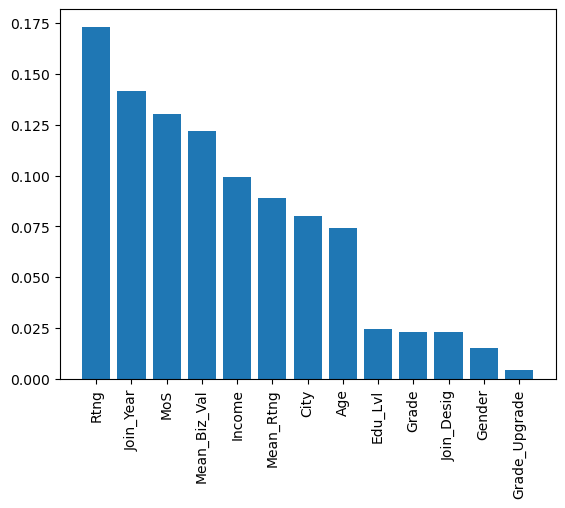

In [741]:
rfc1.fit(X_train_scaled2_v1, y_train2_v1)
ser_feat_imp2_v1 = pd.Series(dict(zip(X_train2_v1.columns, rfc1.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp2_v1.index, ser_feat_imp2_v1.values)
plt.xticks(rotation=90)
plt.show()

## **Trail 2:**
Features used to predict Churn:
- ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Trend_Rtng', 'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct']
- Using 10-fold cross-validation, Mean Accuracy achieved: 88.1%, Stdev:2.5%
- ~2% Improvement from Trail1

In [650]:
feat_set2 = ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 
             'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Trend_Rtng', 
             'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct', 
             'Churn']
df_agg_final_ml2_v2 = df_agg_final2[feat_set2].copy()

# Categorical to Numerical
tar_enc = TargetEncoder()
df_agg_final_ml2_v2['City'] = tar_enc.fit_transform(df_agg_final_ml2_v2['City'], df_agg_final_ml2_v2['Churn'])

print('Shape:', df_agg_final_ml2_v2.shape)
df_agg_final_ml2_v2.head()

Shape: (2381, 18)


,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Income,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct,Churn
0,0.0,28.0,2,0.769859,2018,1,4.0,57387,1,0,2,2.0,0.0,571860.0,-571860.0,0.667,1.0,1
1,0.0,31.0,2,0.684190,2020,2,2.0,67016,2,0,1,1.0,0.0,0.0,0.0,1.000,0.0,0
2,0.0,43.0,2,0.816064,2019,2,5.0,65603,2,0,1,1.0,0.0,70000.0,-70000.0,0.800,0.0,1
3,0.0,29.0,0,0.706553,2019,1,3.0,46368,1,0,1,1.0,0.0,40120.0,-40120.0,0.667,1.0,1
4,1.0,31.0,1,0.702829,2020,3,6.0,78728,3,0,2,1.6,0.4,253000.0,-253000.0,0.800,0.0,0


In [652]:
# Splitting b/w independent and dependent features
X2_v2 = df_agg_final_ml2_v2.iloc[:, :-1]
y2_v2 = df_agg_final_ml2_v2.iloc[:, -1]

In [653]:
# Train-Test split
X_train2_v2, X_test2_v2, y_train2_v2, y_test2_v2 = train_test_split(X2_v2, y2_v2, test_size=0.2, random_state=42)
print('Shape of Xtrain:', X_train2_v2.shape)
print('Shape of ytrain:', y_train2_v2.shape)
print('Shape of Xtest:', X_test2_v2.shape)
print('Shape of ytest:', y_test2_v2.shape)

Shape of Xtrain: (1904, 17)
Shape of ytrain: (1904,)
Shape of Xtest: (477, 17)
Shape of ytest: (477,)


In [654]:
# Scaling the Data
std_scaler = StandardScaler()
X_train_scaled2_v2 = std_scaler.fit_transform(X_train2_v2)
X_test_scaled2_v2 = std_scaler.transform(X_test2_v2)

In [742]:
rfc2 = RandomForestClassifier(random_state=42)
cross_val_rfc_feat_set2 = cross_val_score(rfc2, X_train_scaled2_v2, y_train2_v2, cv=10, scoring='accuracy')
print(cross_val_rfc_feat_set2)
print('-'*50)
pd.Series(cross_val_rfc_feat_set2).describe()

[0.85340314 0.89528796 0.89528796 0.91623037 0.9        0.84736842
 0.89473684 0.87894737 0.84210526 0.88947368]
--------------------------------------------------


count    10.000000
mean      0.881284
std       0.025122
min       0.842105
25%       0.859789
50%       0.892105
75%       0.895288
max       0.916230
dtype: float64

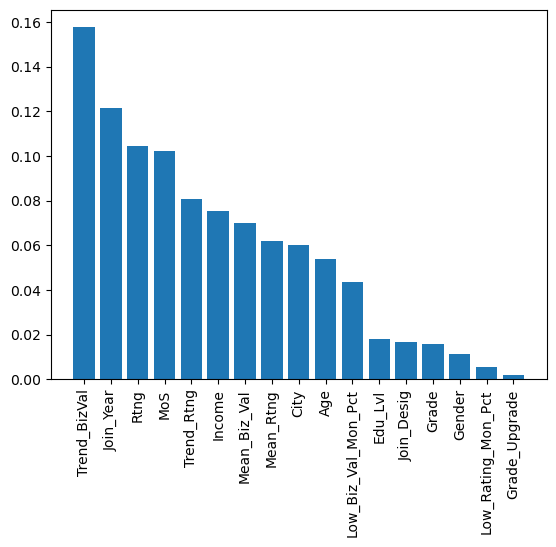

In [743]:
rfc2.fit(X_train_scaled2_v2, y_train2_v2)
ser_feat_imp2_v2 = pd.Series(dict(zip(X_train2_v2.columns, rfc2.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp2_v2.index, ser_feat_imp2_v2.values)
plt.xticks(rotation=90)
plt.show()

## **Trail 3:**
Features used to predict Churn:
- ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Trend_Rtng', 'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct', 'Tier_in_City_Bizval']
- Using 10-fold cross-validation, Mean Accuracy achieved: 88.4%, Stdev:2.5%
- Very slight improvement from Trail2

In [736]:
feat_set = ['Gender', 'Age', 'Edu_Lvl', 'City', 'Join_Year', 'Join_Desig', 'MoS', 
             'Income', 'Grade', 'Grade_Upgrade', 'Rtng', 'Mean_Rtng', 'Trend_Rtng', 
             'Mean_Biz_Val', 'Trend_BizVal', 'Low_Biz_Val_Mon_Pct', 'Low_Rating_Mon_Pct', 
             'Tier_in_City_Bizval', 'Churn']
df_agg_final_ml3 = df_agg_final3[feat_set].copy()

# Categorical to Numerical
tar_enc = TargetEncoder()
df_agg_final_ml3['City'] = tar_enc.fit_transform(df_agg_final_ml3['City'], df_agg_final_ml3['Churn'])

print('Shape:', df_agg_final_ml3.shape)
df_agg_final_ml3.head()

Shape: (2381, 19)


,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Income,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct,Tier_in_City_Bizval,Churn
0,0.0,28.0,2,0.769859,2018,1,4.0,57387,1,0,2,2.0,0.0,571860.0,-571860.0,0.667,1.0,1,1
1,0.0,31.0,2,0.684190,2020,2,2.0,67016,2,0,1,1.0,0.0,0.0,0.0,1.000,0.0,3,0
2,0.0,43.0,2,0.816064,2019,2,5.0,65603,2,0,1,1.0,0.0,70000.0,-70000.0,0.800,0.0,2,1
3,0.0,29.0,0,0.706553,2019,1,3.0,46368,1,0,1,1.0,0.0,40120.0,-40120.0,0.667,1.0,2,1
4,1.0,31.0,1,0.702829,2020,3,6.0,78728,3,0,2,1.6,0.4,253000.0,-253000.0,0.800,0.0,1,0


In [737]:
# Splitting b/w independent and dependent features
X3 = df_agg_final_ml3.iloc[:, :-1]
y3 = df_agg_final_ml3.iloc[:, -1]

In [822]:
# Train-Test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
print('Shape of Xtrain:', X_train3.shape)
print('Shape of ytrain:', y_train3.shape)
print('Shape of Xtest:', X_test3.shape)
print('Shape of ytest:', y_test3.shape)

Shape of Xtrain: (1904, 18)
Shape of ytrain: (1904,)
Shape of Xtest: (477, 18)
Shape of ytest: (477,)


In [739]:
# Scaling the Data
std_scaler = StandardScaler()
X_train_scaled3 = std_scaler.fit_transform(X_train3)
X_test_scaled3 = std_scaler.transform(X_test3)

In [744]:
rfc3 = RandomForestClassifier(random_state=42)
cross_val_rfc_feat_set3 = cross_val_score(rfc3, X_train_scaled3, y_train3, cv=10, scoring='accuracy')
print(cross_val_rfc_feat_set3)
print('-'*50)
pd.Series(cross_val_rfc_feat_set3).describe()

[0.86910995 0.89528796 0.88481675 0.92670157 0.9        0.83684211
 0.90526316 0.88421053 0.85789474 0.88421053]
--------------------------------------------------


count    10.000000
mean      0.884434
std       0.025353
min       0.836842
25%       0.872885
50%       0.884514
75%       0.898822
max       0.926702
dtype: float64

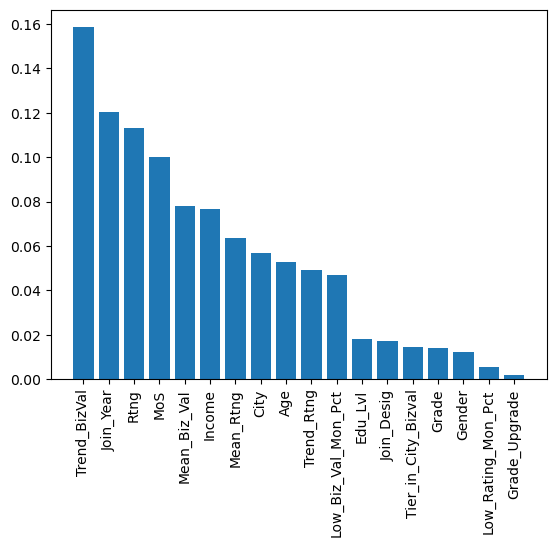

In [745]:
rfc3.fit(X_train_scaled3, y_train3)
ser_feat_imp2_v2 = pd.Series(dict(zip(X_train3.columns, rfc3.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp2_v2.index, ser_feat_imp2_v2.values)
plt.xticks(rotation=90)
plt.show()

# **Final Model Training**
- We will proceed the features we used in Trail2
- We will train RandomForestClassifiers, GradientBoostedClassifers and perform the necessary hyper-parameter tuning
- Since our target vartiable distribution is imbalanced, we will apply SMOTE and then train on a balanced dataset
- These iterations will help us to converge to the best model for the problem statement at hand

In [749]:
df_agg_feat_final = df_agg_final_ml2_v2.copy()
df_agg_feat_final.head()

,Gender,Age,Edu_Lvl,City,Join_Year,Join_Desig,MoS,Income,Grade,Grade_Upgrade,Rtng,Mean_Rtng,Trend_Rtng,Mean_Biz_Val,Trend_BizVal,Low_Biz_Val_Mon_Pct,Low_Rating_Mon_Pct,Churn
0,0.0,28.0,2,0.769859,2018,1,4.0,57387,1,0,2,2.0,0.0,571860.0,-571860.0,0.667,1.0,1
1,0.0,31.0,2,0.684190,2020,2,2.0,67016,2,0,1,1.0,0.0,0.0,0.0,1.000,0.0,0
2,0.0,43.0,2,0.816064,2019,2,5.0,65603,2,0,1,1.0,0.0,70000.0,-70000.0,0.800,0.0,1
3,0.0,29.0,0,0.706553,2019,1,3.0,46368,1,0,1,1.0,0.0,40120.0,-40120.0,0.667,1.0,1
4,1.0,31.0,1,0.702829,2020,3,6.0,78728,3,0,2,1.6,0.4,253000.0,-253000.0,0.800,0.0,0


In [751]:
X = df_agg_feat_final.iloc[: , :-1]
y = df_agg_feat_final.iloc[:, -1]

In [823]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of Xtrain:', X_train.shape)
print('Shape of ytrain:', y_train.shape)
print('Shape of Xtest:', X_test.shape)
print('Shape of ytest:', y_test.shape)

Shape of Xtrain: (1904, 17)
Shape of ytrain: (1904,)
Shape of Xtest: (477, 17)
Shape of ytest: (477,)


In [754]:
# Scaling the Data
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## **Random Forest Classifier: HyperParameter Tuning (Imbalanced Target)**

In [814]:
# Target Class distribution
print('Distribution of Classes')
print(y.value_counts())
print('-'*60)
print('Normalized Distribution of Classes')
print(y.value_counts(normalize=True))

Distribution of Classes
1    1616
0     765
Name: Churn, dtype: int64
------------------------------------------------------------
Normalized Distribution of Classes
1    0.678706
0    0.321294
Name: Churn, dtype: float64


In [767]:
parameters = {
    "n_estimators":[50, 100, 150, 200],
    "max_features":[2, 3, 4, 6, 9, 12],
    "max_depth":[4, 6, 8, 10],
    'criterion' :['gini', 'entropy'],
    "ccp_alpha":[0.00005, 0.0001, 0.001]
}


rfc = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator = rfc,
    param_grid = parameters,
    scoring = "accuracy",
    n_jobs = -1,
    refit=True,               
    cv=5,
    # return_train_score=False
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [5e-05, 0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': [2, 3, 4, 6, 9, 12],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [768]:
grid_search.best_params_

{'ccp_alpha': 5e-05,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 4,
 'n_estimators': 150}

In [807]:
# grid_search.best_estimator_

In [776]:
rfc4 = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=8, max_features=4, ccp_alpha=0.00005, criterion='gini')
cross_val_rfc_train = cross_val_score(rfc4, X_train_scaled, y_train, cv=10, scoring='accuracy')
print('Accuracy for each fold:', cross_val_rfc_train)
print('-'*100)
pd.Series(cross_val_rfc_train).describe()

Accuracy for each fold: [0.87434555 0.91623037 0.90052356 0.90575916 0.91052632 0.84210526
 0.9        0.87368421 0.85263158 0.88947368]
----------------------------------------------------------------------------------------------------


count    10.000000
mean      0.886528
std       0.025055
min       0.842105
25%       0.873850
50%       0.894737
75%       0.904450
max       0.916230
dtype: float64

In [789]:
rfc4.fit(X_train_scaled, y_train)

RandomForestClassifier(ccp_alpha=5e-05, max_depth=8, max_features=4,
                       n_estimators=150, random_state=42)

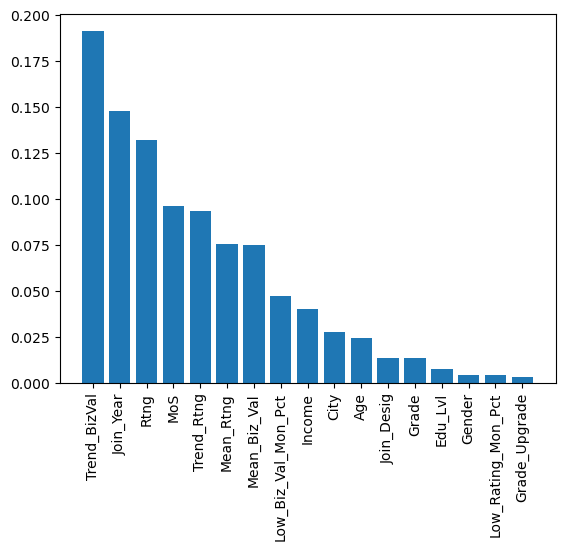

In [808]:
ser_feat_imp_rfc = pd.Series(dict(zip(X_train.columns, rfc4.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp_rfc.index, ser_feat_imp_rfc.values)
plt.xticks(rotation=90)
plt.show()

In [800]:
y_pred = rfc4.predict(X_test_scaled)
proba = rfc4.predict_proba(X_test_scaled)[:, -1]
print("Train accuracy:",rfc4.score(X_train_scaled, y_train))
print("Test accuracy:",rfc4.score(X_test_scaled, y_test))
print("ROC-AUC score: ", roc_auc_score(y_test, proba))
print('-'*60)
print(classification_report(y_test, y_pred))
print('-'*60)
print('Confusion Matrix on Test Set:')
print(confusion_matrix(y_test, y_pred))

Train accuracy: 0.9401260504201681
Test accuracy: 0.8784067085953878
ROC-AUC score:  0.9287257900101937
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       150
           1       0.88      0.95      0.91       327

    accuracy                           0.88       477
   macro avg       0.87      0.84      0.85       477
weighted avg       0.88      0.88      0.88       477

------------------------------------------------------------
Confusion Matrix on Test Set:
[[109  41]
 [ 17 310]]


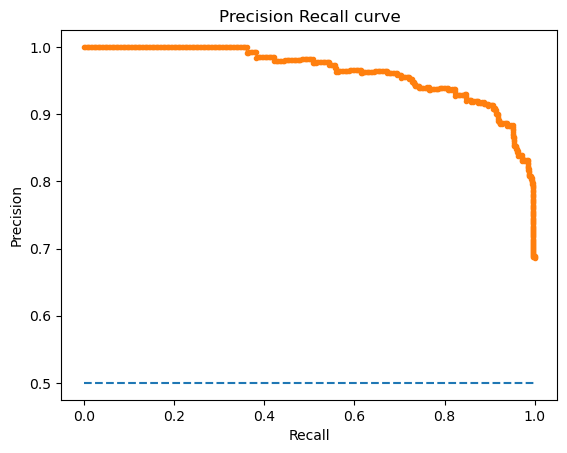

In [806]:
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
precision, recall, thresholds = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.')
plt.title("Precision Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

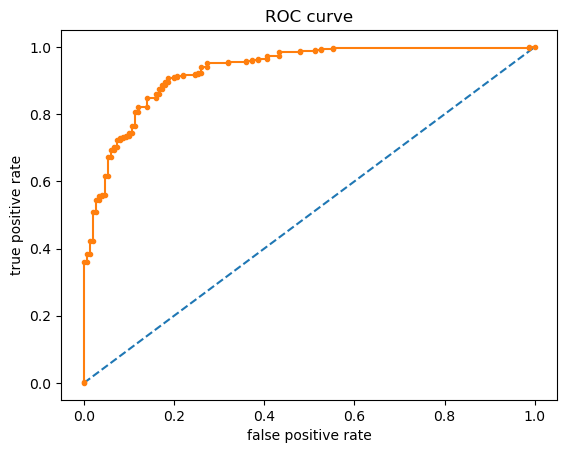

In [805]:
plt.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, thresholds = roc_curve(y_test, proba)
plt.plot(fpr, tpr, marker='.')
plt.title("ROC curve")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

## **Random Forest Classifier: HyperParameter Tuning (Balanced Target)**
- With a balanced dataset: Precison, Recall and Accuracy on test data all improved (improvement is slight)

In [825]:
print('Shape of Xtrain:', X_train_scaled.shape)
print('Shape of ytrain:', y_train.shape)
print('Shape of Xtest:', X_test_scaled.shape)
print('Shape of ytest:', y_test.shape)

Shape of Xtrain: (1904, 17)
Shape of ytrain: (1904,)
Shape of Xtest: (477, 17)
Shape of ytest: (477,)


In [816]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)
X_train_scaled_smot, y_train_smot = sm.fit_resample(X_train_scaled, y_train)

In [826]:
print('Shape of Xtrain:', X_train_scaled_smot.shape)
print('Shape of ytrain:', y_train_smot.shape)
print('Shape of Xtest:', X_test_scaled.shape)
print('Shape of ytest:', y_test.shape)

Shape of Xtrain: (2578, 17)
Shape of ytrain: (2578,)
Shape of Xtest: (477, 17)
Shape of ytest: (477,)


In [827]:
# Target Class distribution
print('Distribution of Classes')
print(y_train_smot.value_counts())
print('-'*60)
print('Normalized Distribution of Classes')
print(y_train_smot.value_counts(normalize=True))

Distribution of Classes
0    1289
1    1289
Name: Churn, dtype: int64
------------------------------------------------------------
Normalized Distribution of Classes
0    0.5
1    0.5
Name: Churn, dtype: float64


In [828]:
parameters = {
    "n_estimators":[50, 100, 150, 200],
    "max_features":[2, 3, 4, 6, 9, 12],
    "max_depth":[4, 6, 8, 10],
    'criterion' :['gini', 'entropy'],
    "ccp_alpha":[0.00005, 0.0001, 0.001]
}


rfc = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator = rfc,
    param_grid = parameters,
    scoring = "accuracy",
    n_jobs = -1,
    refit=True,               
    cv=5,
    # return_train_score=False
)

grid_search.fit(X_train_scaled_smot, y_train_smot)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [5e-05, 0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': [2, 3, 4, 6, 9, 12],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [829]:
grid_search.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 12,
 'n_estimators': 200}

In [830]:
rfc5 = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, max_features=12, ccp_alpha=0.0001, criterion='entropy')
cross_val_rfc_train_smot = cross_val_score(rfc5, X_train_scaled_smot, y_train_smot, cv=10, scoring='accuracy')
print('Accuracy for each fold:', cross_val_rfc_train_smot)
print('-'*100)
pd.Series(cross_val_rfc_train_smot).describe()

Accuracy for each fold: [0.85271318 0.88372093 0.89534884 0.87984496 0.89922481 0.90310078
 0.92248062 0.93023256 0.91050584 0.95330739]
----------------------------------------------------------------------------------------------------


count    10.000000
mean      0.903048
std       0.028319
min       0.852713
25%       0.886628
50%       0.901163
75%       0.919487
max       0.953307
dtype: float64

In [832]:
rfc5.fit(X_train_scaled_smot, y_train_smot)

RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=10,
                       max_features=12, n_estimators=200, random_state=42)

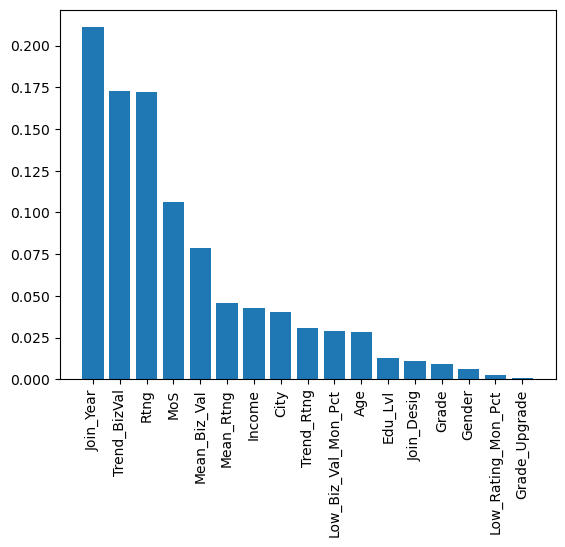

In [833]:
ser_feat_imp_rfc_smot = pd.Series(dict(zip(X_train.columns, rfc5.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp_rfc_smot.index, ser_feat_imp_rfc_smot.values)
plt.xticks(rotation=90)
plt.show()

In [835]:
y_pred = rfc5.predict(X_test_scaled)
proba = rfc5.predict_proba(X_test_scaled)[:, -1]
print("Train accuracy:",rfc5.score(X_train_scaled_smot, y_train_smot))
print("Test accuracy:",rfc5.score(X_test_scaled, y_test))
print("ROC-AUC score: ", roc_auc_score(y_test, proba))
print('-'*60)
print(classification_report(y_test, y_pred))
print('-'*60)
print('Confusion Matrix on Test Set:')
print(confusion_matrix(y_test, y_pred))

Train accuracy: 0.9693560899922421
Test accuracy: 0.8867924528301887
ROC-AUC score:  0.9311926605504588
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       150
           1       0.91      0.93      0.92       327

    accuracy                           0.89       477
   macro avg       0.87      0.86      0.87       477
weighted avg       0.89      0.89      0.89       477

------------------------------------------------------------
Confusion Matrix on Test Set:
[[119  31]
 [ 23 304]]


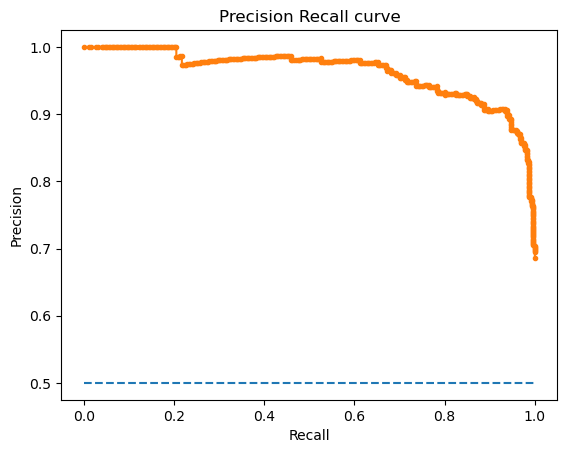

In [836]:
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
precision, recall, thresholds = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.')
plt.title("Precision Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

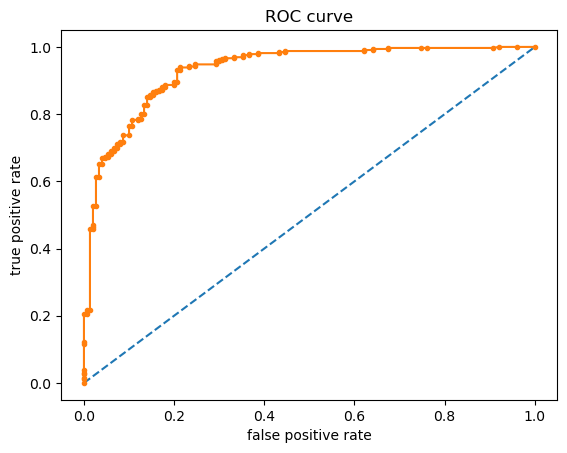

In [837]:
plt.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, thresholds = roc_curve(y_test, proba)
plt.plot(fpr, tpr, marker='.')
plt.title("ROC curve")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

## **Gradient Boosted Classifier: HyperParameter Tuning (Balanced Target)**
- Model is a overfitted model
- Can change a parameters in GridSerach for optimisjng bias/variance tradeoff

In [844]:
parameters = {
    "n_estimators":[50, 100, 150, 200],
    "learning_rate": [0.05, 0.1, 0.2, 0.3],
    "max_depth":[2, 4, 6, 8],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
}


gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(
    estimator = gbc,
    param_grid = parameters,
    scoring = "accuracy",
    n_jobs = -1,
    refit=True,               
    cv=5,
    # return_train_score=False
)

grid_search.fit(X_train_scaled_smot, y_train_smot)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.1, 0.2, 0.5, 0.8, 1]},
             scoring='accuracy')

In [839]:
grid_search.best_params_

{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 8,
 'n_estimators': 200,
 'subsample': 0.5}

In [845]:
gbc1 = GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=8, learning_rate=0.1, loss='exponential', subsample=0.5)
cross_val_gbc_train_smot = cross_val_score(gbc1, X_train_scaled_smot, y_train_smot, cv=10, scoring='accuracy')
print('Accuracy for each fold:', cross_val_gbc_train_smot)
print('-'*100)
pd.Series(cross_val_gbc_train_smot).describe()

Accuracy for each fold: [0.86434109 0.89534884 0.90310078 0.87984496 0.91472868 0.91860465
 0.95348837 0.95736434 0.91828794 0.95719844]
----------------------------------------------------------------------------------------------------


count    10.000000
mean      0.916231
std       0.032310
min       0.864341
25%       0.897287
50%       0.916508
75%       0.944767
max       0.957364
dtype: float64

In [846]:
gbc1.fit(X_train_scaled_smot, y_train_smot)

GradientBoostingClassifier(loss='exponential', max_depth=8, n_estimators=200,
                           random_state=42, subsample=0.5)

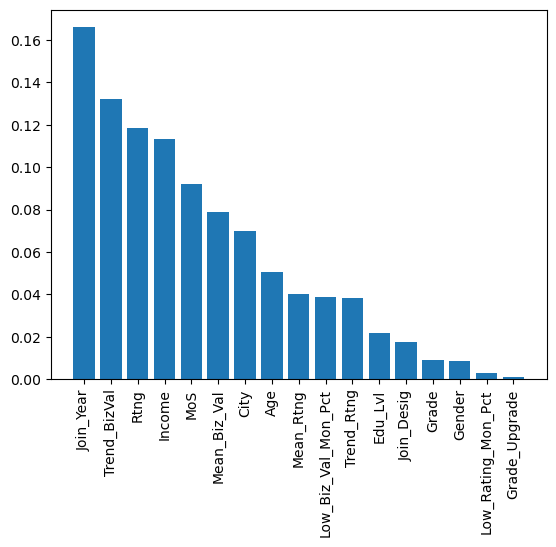

In [847]:
ser_feat_imp_gbc_smot = pd.Series(dict(zip(X_train.columns, gbc1.feature_importances_))).sort_values(ascending=False)
plt.bar(ser_feat_imp_gbc_smot.index, ser_feat_imp_gbc_smot.values)
plt.xticks(rotation=90)
plt.show()

In [848]:
y_pred = gbc1.predict(X_test_scaled)
proba = gbc1.predict_proba(X_test_scaled)[:, -1]
print("Train accuracy:",gbc1.score(X_train_scaled_smot, y_train_smot))
print("Test accuracy:",gbc1.score(X_test_scaled, y_test))
print("ROC-AUC score: ", roc_auc_score(y_test, proba))
print('-'*60)
print(classification_report(y_test, y_pred))
print('-'*60)
print('Confusion Matrix on Test Set:')
print(confusion_matrix(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.8658280922431866
ROC-AUC score:  0.9318246687054027
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       150
           1       0.89      0.92      0.90       327

    accuracy                           0.87       477
   macro avg       0.85      0.84      0.84       477
weighted avg       0.86      0.87      0.86       477

------------------------------------------------------------
Confusion Matrix on Test Set:
[[113  37]
 [ 27 300]]


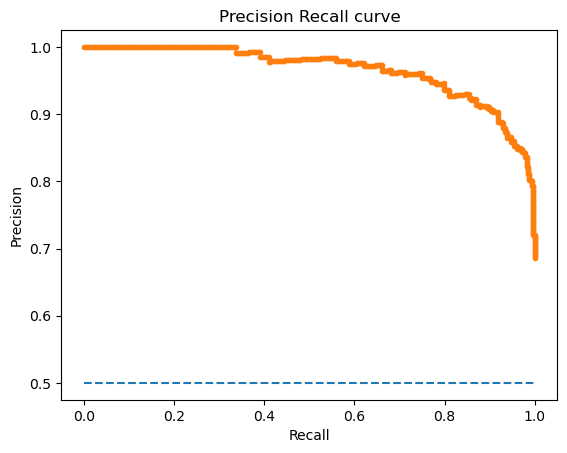

In [851]:
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
precision, recall, thresholds = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.')
plt.title("Precision Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

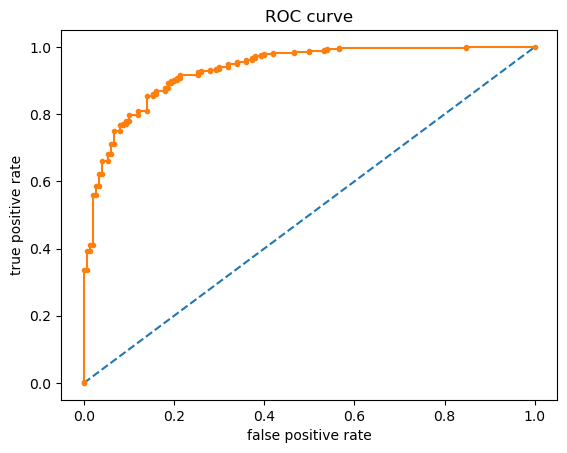

In [852]:
plt.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, thresholds = roc_curve(y_test, proba)
plt.plot(fpr, tpr, marker='.')
plt.title("ROC curve")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

## **Summary**
- Training on balanced dataset gave us better results than training on imbalanced dataset
- RandomForestClassifier seems to be the best candidate for our task

In [850]:
model_summary_dict = {'model': ['Random Forest Classifier (Balanced)', 'Gradient Boosting Classifier(Balanced)'], 
                      'precision' : [0.91, 0.89],
                      'recall' : [0.93, 0.92], 
                      'f1-score' : [0.92, 0.9], 
                      'roc-auc' : [0.93, 0.93], 
                      'test_acc' : [0.89, 0.87]
    }

pd.DataFrame(model_summary_dict)

,model,precision,recall,f1-score,roc-auc,test_acc
0,Random Forest Classifier (Balanced),0.91,0.93,0.92,0.93,0.89
1,Gradient Boosting Classifier(Balanced),0.89,0.92,0.90,0.93,0.87


# **Insights & Recommendation**

***Insights***

- In the given dataset we had information for ~2.3k drivers. Out of these 67% churned and only 33% were retained. Hence the driver attrition problem seems to be heavily affecting the company.
- Few broad insights:
    - Male drivers (0) more than female drivers (1)
    - City20 (C20) has the majority of drivers
    - Most drivers joining Ola in recent years (2018 onwards)
    - Most drivers join Ola at Designation=1
    - Grade=2 is the most common grade drivers are in
    - The latest reported quarterly rating of most drivers is low (1)
    - Only a handful of drivers have received income increment (income increment tallys with grade increment)
    - Most drivers are in the age bracket of 30-35
    - Most common monthly income values are b/w 40k-75k
- After model fitting, the best model was able to achieve a precision of 91%, recall of 93% and an accuracy of 89% on the test data
- The most important features for predicting churn were as follows:
    - Joining Year
    - Trend in Business Value
    - Latest Quarterly Rating
    - Months of Service
    - Mean Business Value

***Recommendations***

1. It is clear that the churn problem is more for new drivers and not so much for old drivers.
- We had already seen that most drivers were new joinees (post 2018) and new drivers are churning more.
- Ola can launch some special offers which makes it lucrative for new joiners to atleast spend a year to 2 years in the company.
    
2. Ola should keep an eye out on the trend in the business value generated by each driver. If the recent monthly business value generated by a driver goes below the mean business value for the past 1year or 2year window, then Ola should seriously look into those drivers.
- Those drivers whose monthly business value generated is starting to show a downward trend can be identifed and ola can dig deeper into the root cause of such a trend.
- A lot of times drivers are not satisfied with drop locations and it can be due to the recommendation engine which recommends rides to customers
- It can also be due to rising fuel prices, or vehicle maintainance cost, etc
- Once the root cause is identified, appropriate actions can be taken
    
3. Similarly drivers whose latest quarterly rating are 1 are very likely to churn
- The company can incentivize drivers with short term rewards for maintaining good customer ratings